In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras import models, layers
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, LearningRateScheduler
# from tensorflow.keras.callbacks import ReduceLROnPlateau, CSVLogger
# from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

os.environ['PYTHONHASHSEED'] = '1'
keras.utils.set_random_seed(42)
tf.random.set_seed(42)
#generate random weights for reproducibility
np.random.seed(42)
import random
random.seed(42)
weights = {}
weights = {key: None for key in np.arange(0, 15)}
weights = {key: 1 for key in np.arange(0, 15)}

In [ ]:
weights

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1}

# Background Research


In [ ]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'test/train/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 9028 files belonging to 15 classes.


tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)

In [54]:
for batch in train_data.take(10):
    print(batch[1][0])

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(11, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(14, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)


In [55]:
validation_data = tf.keras.utils.image_dataset_from_directory(
    'test/validation/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


In [56]:
test_data = tf.keras.utils.image_dataset_from_directory(
    'test/test/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 3000 files belonging to 15 classes.


# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a critical step in understanding and preparing data for various purposes, including machine learning and data-driven decision-making. We can perform EDA to further our understanding of the data, and to make better decisions on how we can process it to make it easier for our model to understand.

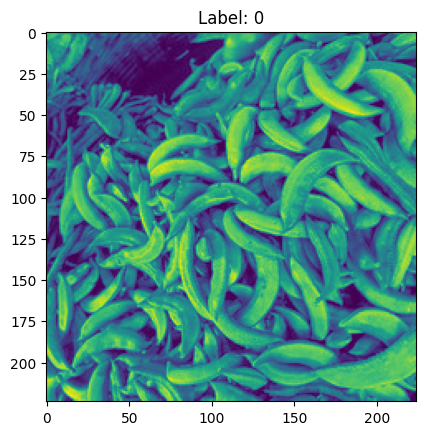

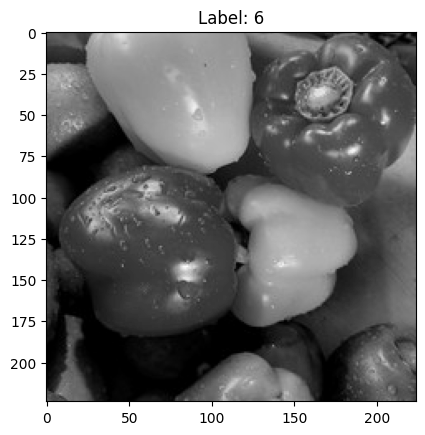

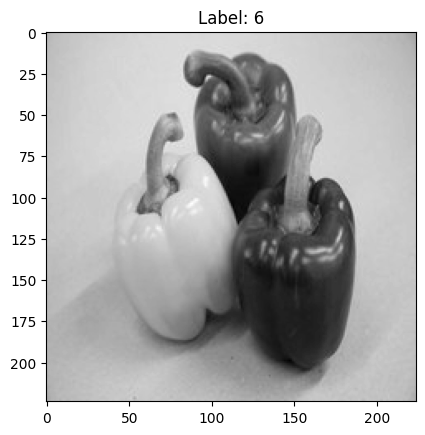

In [57]:
#sample to check if the data is loaded correctly

for batch in train_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0]) 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in test_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()


for batch in validation_data.take(1):
    plt.figure()
    plt.imshow(batch[0][0], cmap='gray') 
    plt.title(f"Label: {batch[1][0]}")
    plt.show()

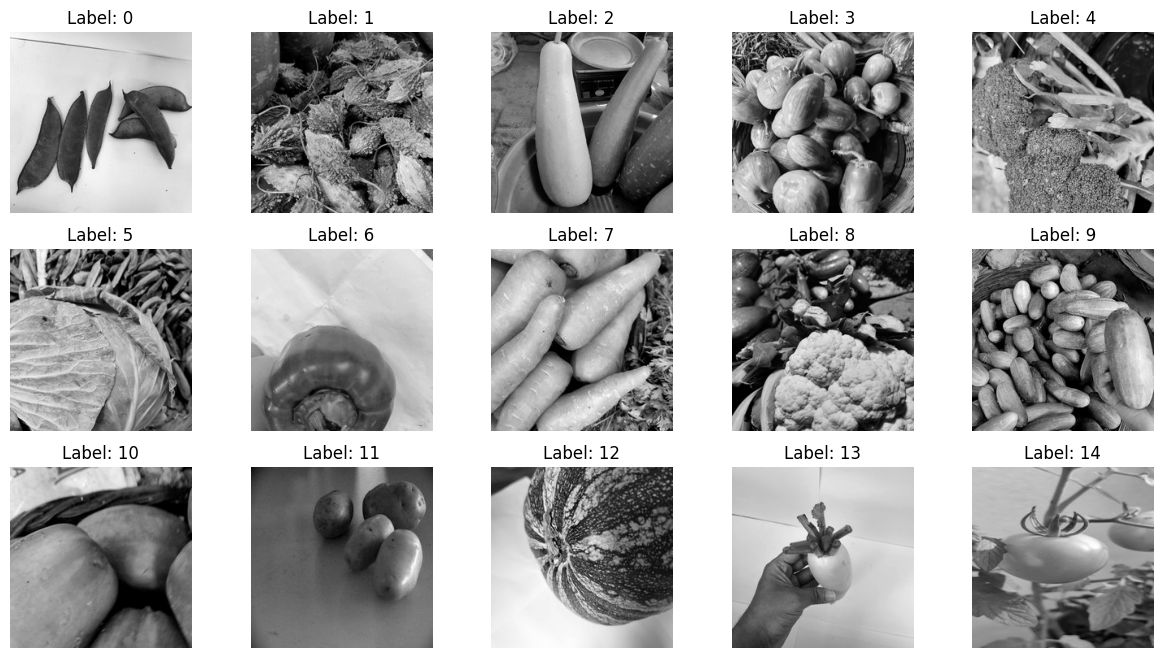

In [58]:
import matplotlib.pyplot as plt

def plot_samples_by_label(data):
    # Create a dictionary to store one sample per label
    samples_by_label = {}
    # Iterate through the training data
    for batch in data:
        image, label = batch[0][0], batch[1][0].numpy()
        
        # Check if a sample for this label already exists
        if label not in samples_by_label:
            samples_by_label[label] = image
            
        # Check if we have samples for all labels
        if len(samples_by_label) == len(set(labels)):
            break
    #use subplot to plot a 5x3 grid of images
    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,8))
    # Loop through each label and subplot
    for label, image in samples_by_label.items():
        row = int(label // 5)
        col = label % 5
        ax = axes[row, col]
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {label}")


labels = [batch[1][0].numpy() for batch in train_data]
# Call the function with your training data
plot_samples_by_label(train_data)


<Axes: title={'center': 'Number of images in each class'}, xlabel='Class'>

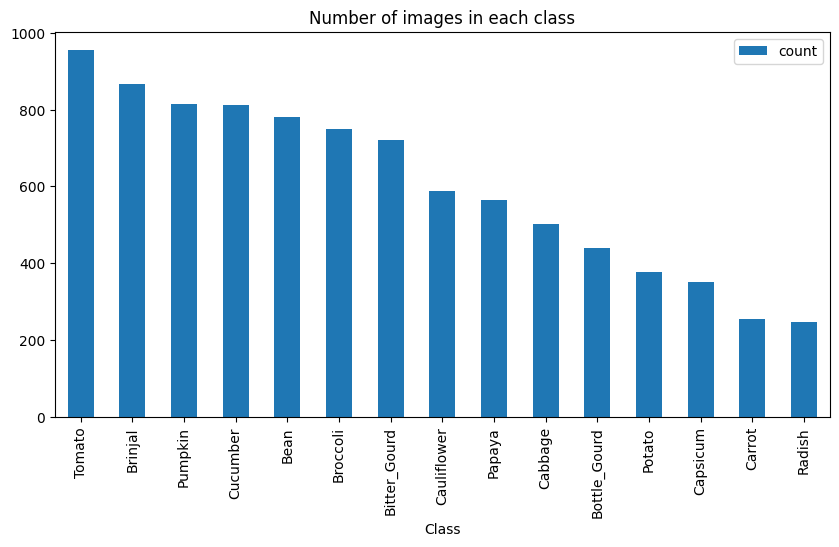

In [59]:
class_counts = {}


for images, labels in train_data:
    for label in labels.numpy():
        class_name = train_data.class_names[label]
        if class_name in class_counts:
            class_counts[class_name] += 1
        else:
            class_counts[class_name] = 1


train_class=pd.DataFrame(list(class_counts.items()),columns=['Class','count'])
train_class=train_class.sort_values(by=['count'],ascending=False)
train_class.plot(kind='bar',figsize=(10,5),title="Number of images in each class",x='Class',y='count')

## Interpreting the Previous Output

Based on the output of the previous cell, we can see that the dataset is not evenly distributed across all labels. This can be problematic for our model, as it may not be able to learn from the data effectively if it is biased towards certain labels.

## Shifting Weights in the Model

One way to address this issue is to shift the weights in the model to account for the uneven distribution of labels. This can be done by assigning higher weights to underrepresented labels and lower weights to overrepresented labels.

For example, we can use the `class_weight` parameter in Keras to assign weights to each class based on their frequency in the dataset. This will ensure that the model pays more attention to underrepresented classes during training.


# Feature engineering or data augmentation


In [60]:
# Convert datasets to NumPy arrays
train_images, train_labels = zip(*[(image, label) for image, label in train_data.as_numpy_iterator()])
validation_images, validation_labels = zip(*[(image, label) for image, label in validation_data.as_numpy_iterator()])
test_images,test_labels= zip(*[(image, label) for image, label in test_data.as_numpy_iterator()])
#train set
X_train = np.concatenate(train_images, axis=0)
y_train = np.concatenate(train_labels, axis=0)

#val
X_val = np.concatenate(validation_images, axis=0) 
y_val = np.concatenate(validation_labels, axis=0)

#test
X_test = np.concatenate(test_images, axis=0)
y_test = np.concatenate(test_labels, axis=0)


In [61]:
# Resize images to (31, 31) using TensorFlow
X_train_resized = tf.image.resize(X_train, (31, 31))
X_val_resized = tf.image.resize(X_val, (31, 31))

# Reshape and normalize
X_train31 = X_train_resized.numpy().reshape(X_train_resized.shape[0], 31, 31, 1).astype('float32') / 255
X_val31 = X_val_resized.numpy().reshape(X_val_resized.shape[0], 31, 31, 1).astype('float32') / 255


validation_labels = to_categorical(y_val)
train_labels = to_categorical(y_train)

# Modelling

## Base Model

We can first try fitting the data in an extremely simple model to get a baseline understanding of the problem. This initial model serves as a reference point for evaluating the performance of more complex models. The base model will be straightforward and quick to implement, which provides a easy way capture the underlying patterns in the data.

### Key Characteristics of the Base Model:

- **Simplicity:** The base model is intentionally kept simple to establish a basic understanding of the data and the problem at hand.

- **Quick Implementation:** It is designed for rapid implementation, allowing for a fast assessment of initial performance.

- **Benchmark:** The base model serves as a benchmark against which more sophisticated models can be compared. Any subsequent model should outperform this baseline to be considered effective.

### Evaluation Metric:

The evaluation metric we will be using will be val accuracy as well as val loss, this will allow us to rougly understand the model's accuracy (val accuracy) as well as its rate of error (val loss)



In [62]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
    # Plot training & validation accuracy values
    ax = axes[1]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax = axes[0]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')

Epoch 1/10
283/283 - 3s - loss: 2.3878 - accuracy: 0.1966 - val_loss: 2.0861 - val_accuracy: 0.3433 - 3s/epoch - 10ms/step
Epoch 2/10
283/283 - 2s - loss: 1.8695 - accuracy: 0.3920 - val_loss: 1.8413 - val_accuracy: 0.3953 - 2s/epoch - 6ms/step
Epoch 3/10
283/283 - 2s - loss: 1.6071 - accuracy: 0.4755 - val_loss: 1.6083 - val_accuracy: 0.4610 - 2s/epoch - 6ms/step
Epoch 4/10
283/283 - 2s - loss: 1.3506 - accuracy: 0.5531 - val_loss: 1.3957 - val_accuracy: 0.5397 - 2s/epoch - 6ms/step
Epoch 5/10
283/283 - 2s - loss: 1.1608 - accuracy: 0.6194 - val_loss: 1.2887 - val_accuracy: 0.5890 - 2s/epoch - 6ms/step
Epoch 6/10
283/283 - 2s - loss: 1.0160 - accuracy: 0.6638 - val_loss: 1.1681 - val_accuracy: 0.6140 - 2s/epoch - 6ms/step
Epoch 7/10
283/283 - 2s - loss: 0.9155 - accuracy: 0.7017 - val_loss: 0.9766 - val_accuracy: 0.6847 - 2s/epoch - 6ms/step
Epoch 8/10
283/283 - 2s - loss: 0.7995 - accuracy: 0.7394 - val_loss: 1.1524 - val_accuracy: 0.6430 - 2s/epoch - 6ms/step
Epoch 9/10
283/283 - 2s

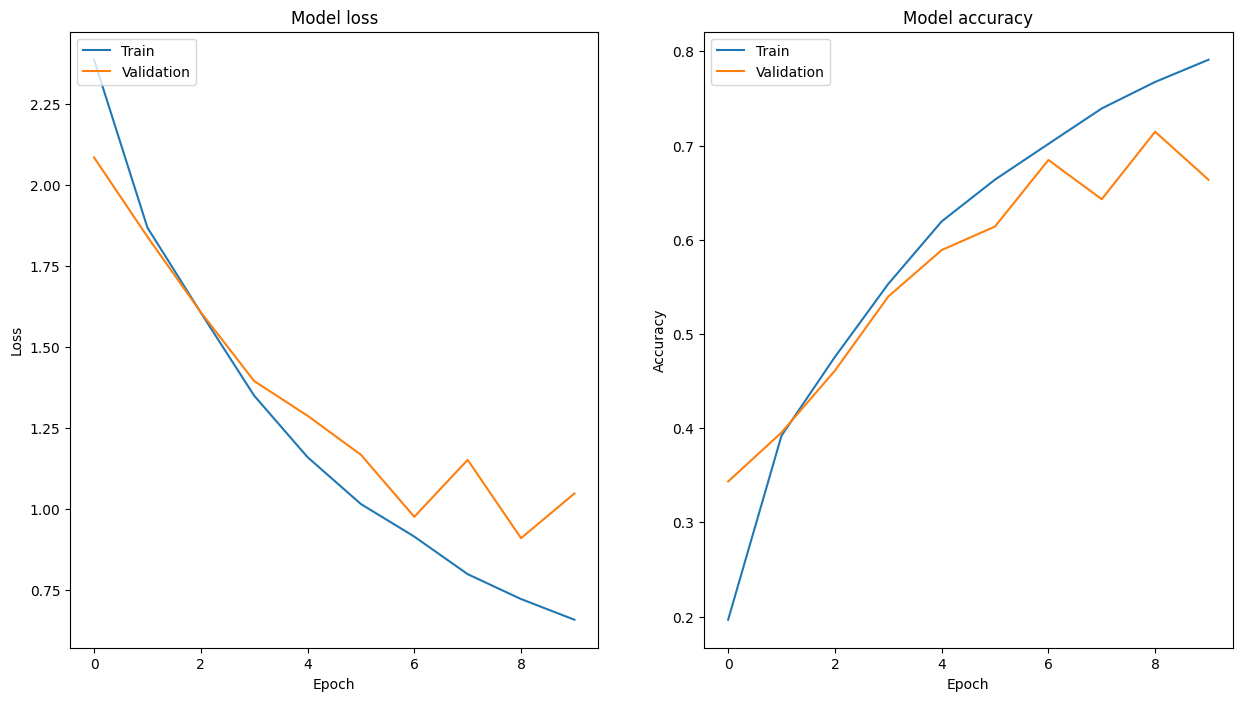

In [63]:
df31 = pd.DataFrame(columns = ['Model Name', 'Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss', 'History'])


model_31 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_31.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_31.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=10, batch_size=32, verbose=2, class_weight = weights)
scores = model_31.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['Base 31 Model', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


In [64]:
X_train_resized = tf.image.resize(X_train, (128, 128))
X_val_resized = tf.image.resize(X_val, (128, 128))

# Reshape and normalize
X_train128 = X_train_resized.numpy().reshape(X_train_resized.shape[0], 128, 128, 1).astype('float32') / 255
X_val128 = X_val_resized.numpy().reshape(X_val_resized.shape[0], 128, 128, 1).astype('float32') / 255

Epoch 1/10
283/283 - 4s - loss: 2.0055 - accuracy: 0.3559 - val_loss: 1.5882 - val_accuracy: 0.4933 - 4s/epoch - 13ms/step
Epoch 2/10
283/283 - 3s - loss: 1.1541 - accuracy: 0.6382 - val_loss: 1.2043 - val_accuracy: 0.6240 - 3s/epoch - 11ms/step
Epoch 3/10
283/283 - 3s - loss: 0.6719 - accuracy: 0.7907 - val_loss: 0.9256 - val_accuracy: 0.7210 - 3s/epoch - 11ms/step
Epoch 4/10
283/283 - 3s - loss: 0.3380 - accuracy: 0.8938 - val_loss: 1.0878 - val_accuracy: 0.6997 - 3s/epoch - 10ms/step
Epoch 5/10
283/283 - 3s - loss: 0.1726 - accuracy: 0.9481 - val_loss: 0.8825 - val_accuracy: 0.7907 - 3s/epoch - 10ms/step
Epoch 6/10
283/283 - 3s - loss: 0.1065 - accuracy: 0.9670 - val_loss: 1.0662 - val_accuracy: 0.7527 - 3s/epoch - 11ms/step
Epoch 7/10
283/283 - 3s - loss: 0.0769 - accuracy: 0.9774 - val_loss: 1.0018 - val_accuracy: 0.7847 - 3s/epoch - 11ms/step
Epoch 8/10
283/283 - 3s - loss: 0.0655 - accuracy: 0.9790 - val_loss: 1.1594 - val_accuracy: 0.7670 - 3s/epoch - 10ms/step
Epoch 9/10
283/2

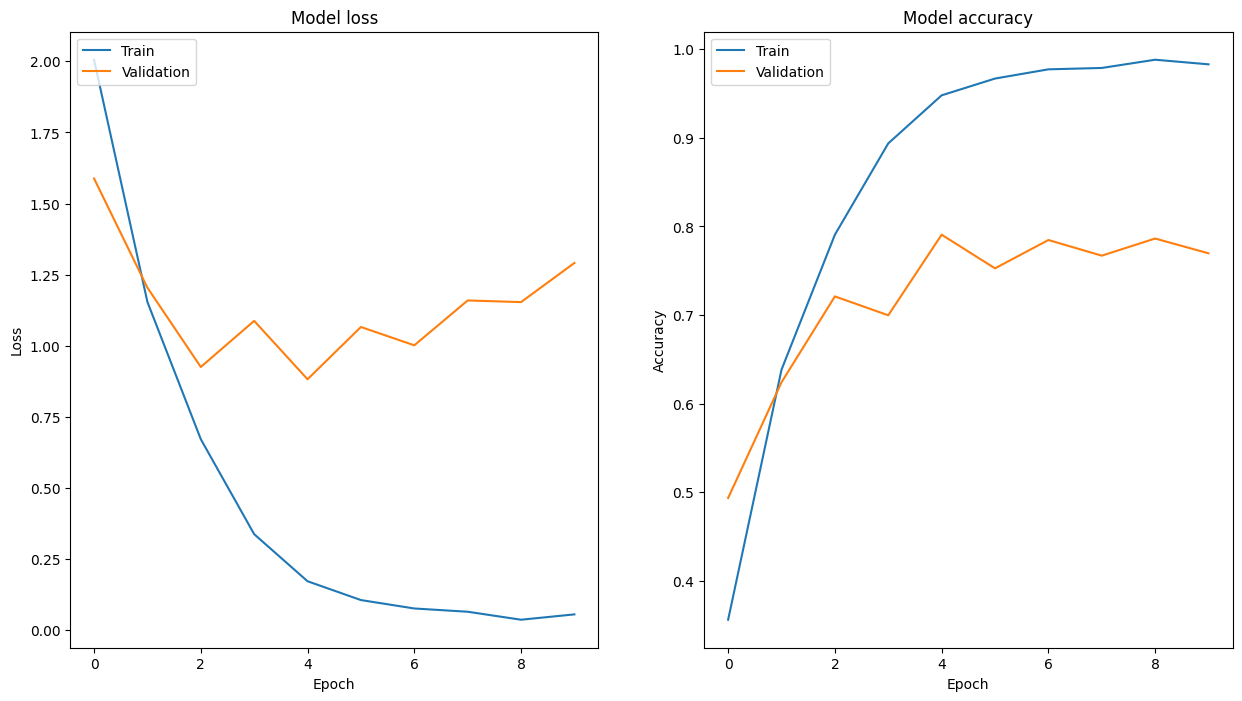

In [65]:
df128 = pd.DataFrame(columns = ['Model', 'Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss', 'History'])

model_128 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_128.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_128.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
 epochs=10, batch_size=32, verbose=2, class_weight = weights)
scores = model_128.evaluate(X_val128, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['Base 128 Model', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


## Base Model Evaluation

As we can see, the base model has achieved a decent accuracy of around 75% for both after 10 epochs. This level of accuracy provides valuable insights into the nature of the dataset and indicates that the dataset is suitable for modeling.

### Accuracy Interpretation:

- **Decent Performance:** An accuracy of 75% suggests that the base model is able to correctly predict the target variable for 75% of the instances in the dataset. This indicates a solid performance, but there may still be room for improvement.

- **Model Feasibility:** The achieved accuracy reaffirms that the dataset contains discernible patterns that the model is capturing. The feasibility of modeling is supported by the ability to achieve a reasonably high accuracy.

- **Baseline for Comparison:** The 75% accuracy serves as a baseline for evaluating the performance of more complex models. Any subsequent model should aim to surpass this accuracy to demonstrate significant improvement.

### Loss Interpretation:

#### 128x128 Graph:

- **Training Progress:** The loss decreases over the 10 epochs, indicating effective learning from the training data. However we should also note the increase in loss after the 5th epoch, as this is the base model there is really no need to take precaution for this specific model, however we should keep in mind that when we are trying other actual model structures, we can use a callback to prevent the model from overfitting.

- **Validation Loss Interpretation:** The validation loss also decreases, suggesting that the model generalizes well to unseen data.

#### 31x31 Graph:

- **Training Progress:** Similar to the other graph, the val-loss decreases after 10 epochs, showing effective learning from the training data.

- **Validation Loss Interpretation:** The validation loss decreases, indicating good generalization to unseen data.

### Comparison:

- **Accuracy Comparison:** Both 128x128 and 31x31 models achieve around 75% accuracy, suggesting that the model is performing consistently across different resolutions.

- **Loss Comparison:** The loss graphs for both resolutions show a consistent decrease, indicating effective learning. The smaller graph (31x31) might have slightly more fluctuations, but the overall trend is still downward.

In summary, the base model demonstrates promising performance, however some overfitting can be seen and further optimization and exploration can likely yield even better results. 


## Model Improvements
1. **Advanced Architectures:**
   - **Description:** Consider more advanced neural network architectures such as ResNet, Inception, or EfficientNet, depending on the nature of the problem. These architectures often capture intricate patterns more effectively.
   - **Benefits:** Enhanced representational capacity can lead to better model performance.


2. **Data Augmentation:**
   - **Description:** Data augmentation involves applying random transformations to the training data, such as rotation, scaling, and flipping. This increases the diversity of the training set, helping the model generalize better to different variations of the input data.
   - **Benefits:** Mitigates overfitting by exposing the model to a wider range of variations in the data.

3. **Batch Normalization:**
   - **Description:** Batch normalization normalizes the input of each layer in a neural network to have zero mean and unit variance. This can accelerate training, improve model stability, and reduce sensitivity to weight initialization.
   - **Benefits:** Enhances convergence speed and can make the model less dependent on the choice of hyperparameters.

4. **Learning Rate Scheduling:**
   - **Description:** Adjusting the learning rate during training can be beneficial. For example, starting with a higher learning rate and gradually reducing it as training progresses can help the model converge more effectively.
   - **Benefits:** Can improve convergence, prevent overshooting, and result in a more stable training process.

5. **Regularization Techniques:**
   - **Description:** Techniques like dropout, L1, and L2 regularization can be applied to prevent overfitting. Dropout randomly drops units during training, while L1 and L2 regularization penalize large weights.
   - **Benefits:** Helps the model generalize better to new data and reduces the risk of overfitting.

6. **Early Stopping:**
   - **Description:** Monitor the validation loss during training and stop training when the loss stops improving. This prevents overfitting and saves computational resources.
   - **Benefits:** Guards against overfitting and ensures the model is not trained for too many epochs.
7. **Adjusting Weights:**
   - **Description:** We can adjust the weights in order to account for the imbalanced distribution of the dataset.
   - **Benefits:** Helps address the issue of imbalanced classes by assigning higher weights to under-represented classes during training. This ensures that the model pays more attention to minority classes, improving overall predictive performance and reducing bias towards the majority class.


## 3. Model Structures/Advanced Architecture

In our quest to enhance the performance of our neural network, we'll explore two well-established architectures designed by experts: AlexNet and LeNet.

### 1. AlexNet:
- **Description:**
  - Input Layer:
    - Shape: 227x227x3 (color images with RGB channels).
  - Convolutional Layer 1:
    - Filters: 96
    - Kernel Size: 11x11
    - Activation Function: ReLU
    - Max Pooling: 3x3, stride 2
  - Convolutional Layer 2:
    - Filters: 256
    - Kernel Size: 5x5
    - Activation Function: ReLU
    - Max Pooling: 3x3, stride 2
  - Convolutional Layer 3:
    - Filters: 384
    - Kernel Size: 3x3
    - Activation Function: ReLU
  - Convolutional Layer 4:
    - Filters: 384
    - Kernel Size: 3x3
    - Activation Function: ReLU
  - Convolutional Layer 5:
    - Filters: 256
    - Kernel Size: 3x3
    - Activation Function: ReLU
    - Max Pooling: 3x3, stride 2
  - Fully Connected Layer 1:
    - Neurons: 4096
    - Activation Function: ReLU
  - Fully Connected Layer 2:
    - Neurons: 4096
    - Activation Function: ReLU
  - Output Layer:
    - Neurons: Number of classes in the task
    - Activation Function: Typically softmax for classification tasks.

### 2. LeNet:
- **Description:**
  - Input Layer:
    - Shape: 32x32 (for grayscale images) or 32x32x3 (for color images with RGB channels).
  - Convolutional Layer 1:
    - Filters: 6
    - Kernel Size: 5x5
    - Activation Function: Tanh
    - Max Pooling: 2x2, stride 2
  - Convolutional Layer 2:
    - Filters: 16
    - Kernel Size: 5x5
    - Activation Function: Tanh
    - Max Pooling: 2x2, stride 2
  - Fully Connected Layer 1:
    - Neurons: 120
    - Activation Function: Tanh
  - Fully Connected Layer 2:
    - Neurons: 84
    - Activation Function: Tanh
  - Output Layer:
    - Neurons: Number of classes in the task
    - Activation Function: Typically softmax for classification tasks.



The input layer will be scaled to fit the images we are using (31x31 and 128x128)

In [66]:
def AlexNet(input_shape, num_classes=15):
    model = models.Sequential()
    # Convolutional Layer 1
    model.add(layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=(input_shape, input_shape, 1)))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(256, (5, 5), padding='same', activation='relu'))

    # Adjust the pooling parameters or remove pooling if necessary
    # model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Convolutional Layer 3
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Convolutional Layer 4
    model.add(layers.Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Convolutional Layer 5
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten the output before the fully connected layers
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(layers.Dense(4096, activation='relu'))

    # Fully Connected Layer 2
    model.add(layers.Dense(4096, activation='relu'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [67]:

def Lenet(input_shape, num_classes=15):
    model = models.Sequential()

    # Convolutional Layer 1
    model.add(layers.Conv2D(6, (5, 5), activation='tanh', input_shape=(input_shape, input_shape,1)))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(16, (5, 5), activation='tanh'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Flatten the output before the fully connected layers
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(layers.Dense(120, activation='tanh'))

    # Fully Connected Layer 2
    model.add(layers.Dense(84, activation='tanh'))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

Epoch 1/10
283/283 - 2s - loss: 2.3476 - accuracy: 0.2481 - val_loss: 2.2141 - val_accuracy: 0.3007 - 2s/epoch - 7ms/step
Epoch 2/10
283/283 - 2s - loss: 1.9473 - accuracy: 0.3879 - val_loss: 1.9234 - val_accuracy: 0.3840 - 2s/epoch - 5ms/step
Epoch 3/10
283/283 - 2s - loss: 1.6951 - accuracy: 0.4641 - val_loss: 1.8213 - val_accuracy: 0.4183 - 2s/epoch - 5ms/step
Epoch 4/10
283/283 - 2s - loss: 1.5316 - accuracy: 0.5197 - val_loss: 1.6239 - val_accuracy: 0.4853 - 2s/epoch - 5ms/step
Epoch 5/10
283/283 - 2s - loss: 1.3912 - accuracy: 0.5663 - val_loss: 1.5199 - val_accuracy: 0.5283 - 2s/epoch - 5ms/step
Epoch 6/10
283/283 - 2s - loss: 1.2771 - accuracy: 0.6020 - val_loss: 1.4308 - val_accuracy: 0.5377 - 2s/epoch - 5ms/step
Epoch 7/10
283/283 - 2s - loss: 1.1564 - accuracy: 0.6392 - val_loss: 1.3464 - val_accuracy: 0.5633 - 2s/epoch - 5ms/step
Epoch 8/10
283/283 - 2s - loss: 1.0615 - accuracy: 0.6677 - val_loss: 1.3029 - val_accuracy: 0.5880 - 2s/epoch - 5ms/step
Epoch 9/10
283/283 - 2s 

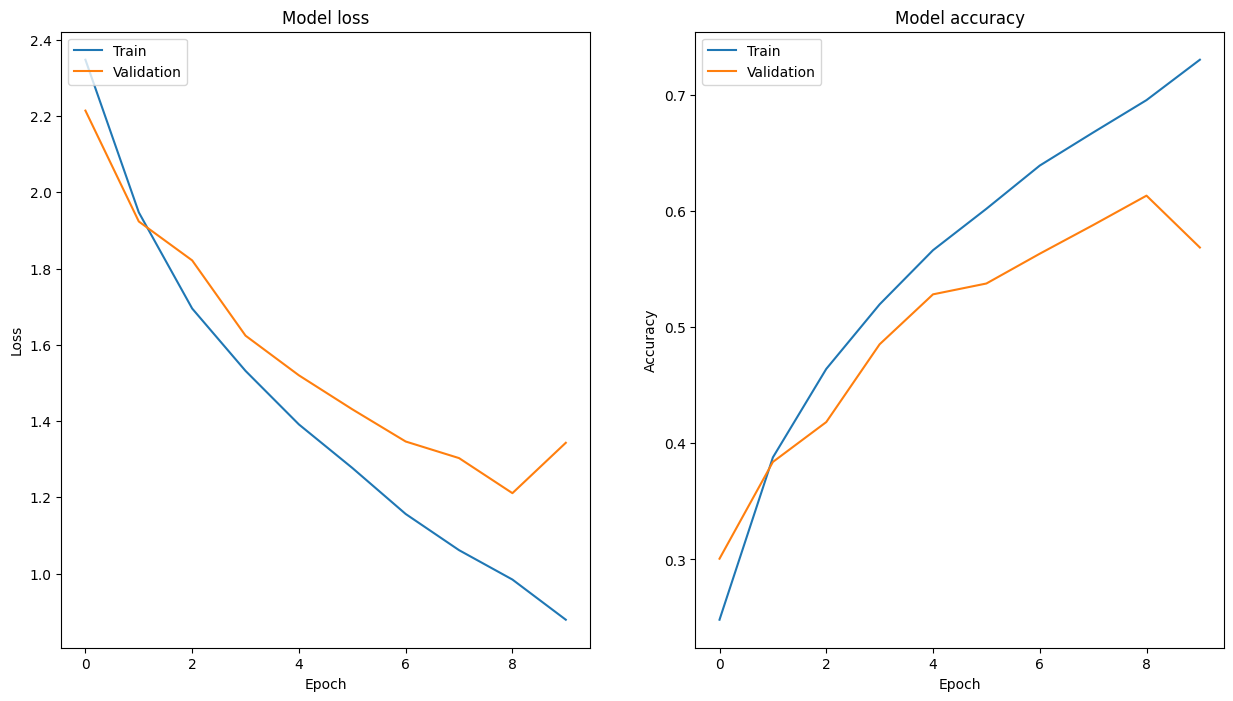

In [68]:
# 31x31 LeNet

model = Lenet(31)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=10, batch_size=32, verbose=2, class_weight = weights)
scores = model.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

plot_history(history)
df31.loc[len(df31)] = ['LeNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

Epoch 1/10
283/283 - 4s - loss: 2.6459 - accuracy: 0.0979 - val_loss: 2.7857 - val_accuracy: 0.0667 - 4s/epoch - 13ms/step
Epoch 2/10
283/283 - 3s - loss: 2.6400 - accuracy: 0.1029 - val_loss: 2.7882 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 3/10
283/283 - 3s - loss: 2.6383 - accuracy: 0.1030 - val_loss: 2.7834 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 4/10
283/283 - 3s - loss: 2.6380 - accuracy: 0.1038 - val_loss: 2.7775 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 5/10
283/283 - 3s - loss: 2.6381 - accuracy: 0.1041 - val_loss: 2.7912 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 6/10
283/283 - 3s - loss: 2.6378 - accuracy: 0.1056 - val_loss: 2.7846 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 7/10
283/283 - 3s - loss: 2.6373 - accuracy: 0.1025 - val_loss: 2.7905 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 8/10
283/283 - 3s - loss: 2.6373 - accuracy: 0.1035 - val_loss: 2.8042 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 9/10
283/283 - 3s

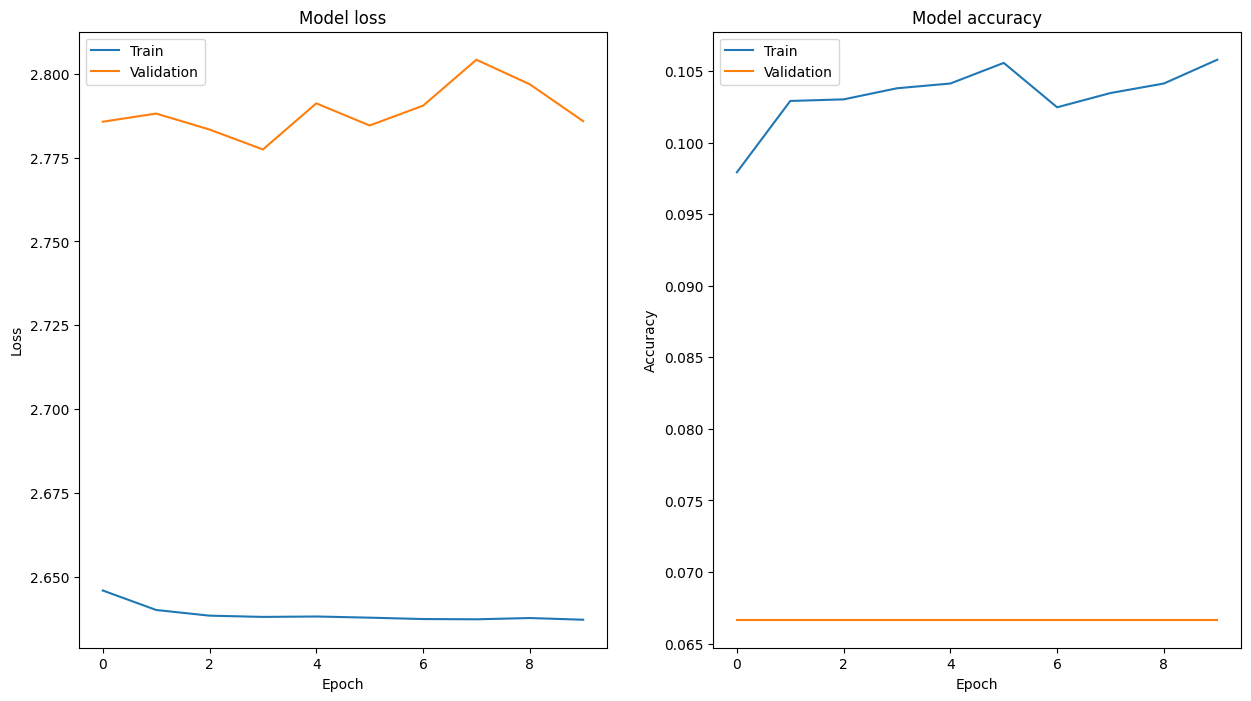

In [69]:
# 31x31 alexnet 

model = AlexNet(31)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=10, batch_size=32, verbose=2, class_weight = weights)


scores = model.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['AlexNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

In [70]:
df31.sort_values(by=['Validation Accuracy'],ascending=False)

Model Name  Train Accuracy  Validation Accuracy  Train Loss  \
0  Base 31 Model        0.791094             0.663667    0.658891   
1          LeNet        0.730394             0.568667    0.879061   
2        AlexNet        0.105782             0.066667    2.637136   

   Validation Loss                                            History  
0         1.048594  <keras.callbacks.History object at 0x00000292A...  
1         1.343069  <keras.callbacks.History object at 0x000002976...  
2         2.785906  <keras.callbacks.History object at 0x000002978...

| Model Name      | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss | Evaluation                                    |
| --------------- | -------------- | ------------------- | ---------- | ---------------- | --------------------------------------------- |
| Base 31 Model   | 78.11%         | 68.77%              | 0.6784     | 1.0055           | Reasonable performance, slight overfitting.   |
| LeNet           | 73.01%         | 57.37%              | 0.8786     | 1.3403           | Signs of overfitting, might perform better with regularization. |
| AlexNet         | 10.58%         | 6.67%               | 2.6364     | 2.7977           | Poor performance. |




Epoch 1/10
283/283 - 3s - loss: 1.7415 - accuracy: 0.4464 - val_loss: 1.4102 - val_accuracy: 0.5543 - 3s/epoch - 9ms/step
Epoch 2/10
283/283 - 2s - loss: 0.9844 - accuracy: 0.6986 - val_loss: 1.0955 - val_accuracy: 0.6650 - 2s/epoch - 6ms/step
Epoch 3/10
283/283 - 2s - loss: 0.5125 - accuracy: 0.8607 - val_loss: 1.0116 - val_accuracy: 0.6893 - 2s/epoch - 7ms/step
Epoch 4/10
283/283 - 2s - loss: 0.2301 - accuracy: 0.9484 - val_loss: 1.1700 - val_accuracy: 0.6587 - 2s/epoch - 7ms/step
Epoch 5/10
283/283 - 2s - loss: 0.0942 - accuracy: 0.9843 - val_loss: 1.0573 - val_accuracy: 0.7020 - 2s/epoch - 7ms/step
Epoch 6/10
283/283 - 2s - loss: 0.0371 - accuracy: 0.9962 - val_loss: 1.1027 - val_accuracy: 0.7087 - 2s/epoch - 7ms/step
Epoch 7/10
283/283 - 2s - loss: 0.0154 - accuracy: 0.9993 - val_loss: 1.1509 - val_accuracy: 0.7013 - 2s/epoch - 7ms/step
Epoch 8/10
283/283 - 2s - loss: 0.0083 - accuracy: 1.0000 - val_loss: 1.1600 - val_accuracy: 0.7070 - 2s/epoch - 7ms/step
Epoch 9/10
283/283 - 2s 

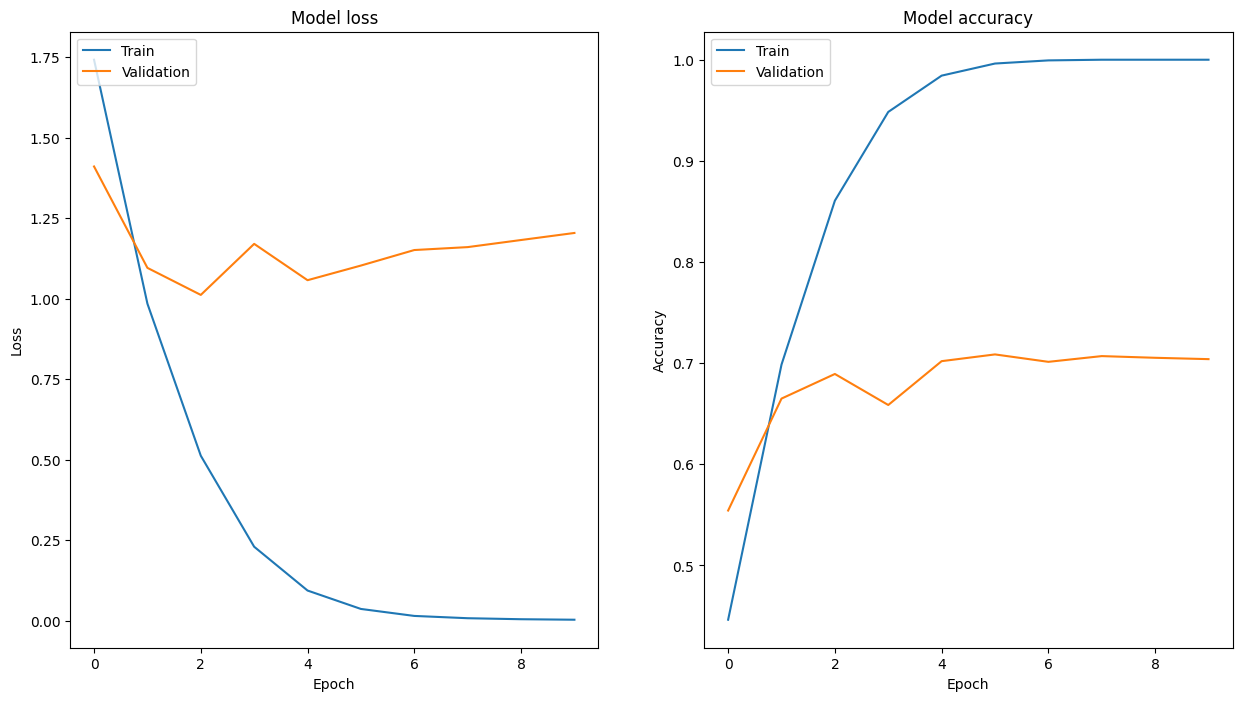

In [71]:
model = Lenet(128)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=10, batch_size=32, verbose=2, class_weight = weights)


scores = model.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['LeNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

Epoch 1/10
283/283 - 7s - loss: 2.6571 - accuracy: 0.0977 - val_loss: 2.7917 - val_accuracy: 0.0667 - 7s/epoch - 25ms/step
Epoch 2/10
283/283 - 5s - loss: 2.6406 - accuracy: 0.1020 - val_loss: 2.7924 - val_accuracy: 0.0667 - 5s/epoch - 19ms/step
Epoch 3/10
283/283 - 5s - loss: 2.6387 - accuracy: 0.1037 - val_loss: 2.7831 - val_accuracy: 0.0667 - 5s/epoch - 19ms/step
Epoch 4/10
283/283 - 5s - loss: 2.6381 - accuracy: 0.1041 - val_loss: 2.7784 - val_accuracy: 0.0667 - 5s/epoch - 19ms/step
Epoch 5/10
283/283 - 5s - loss: 2.6380 - accuracy: 0.1042 - val_loss: 2.7912 - val_accuracy: 0.0667 - 5s/epoch - 19ms/step
Epoch 6/10
283/283 - 5s - loss: 2.6378 - accuracy: 0.1054 - val_loss: 2.7869 - val_accuracy: 0.0667 - 5s/epoch - 19ms/step
Epoch 7/10
283/283 - 5s - loss: 2.6373 - accuracy: 0.1025 - val_loss: 2.7927 - val_accuracy: 0.0667 - 5s/epoch - 19ms/step
Epoch 8/10
283/283 - 5s - loss: 2.6372 - accuracy: 0.1038 - val_loss: 2.8033 - val_accuracy: 0.0667 - 5s/epoch - 19ms/step
Epoch 9/10
283/2

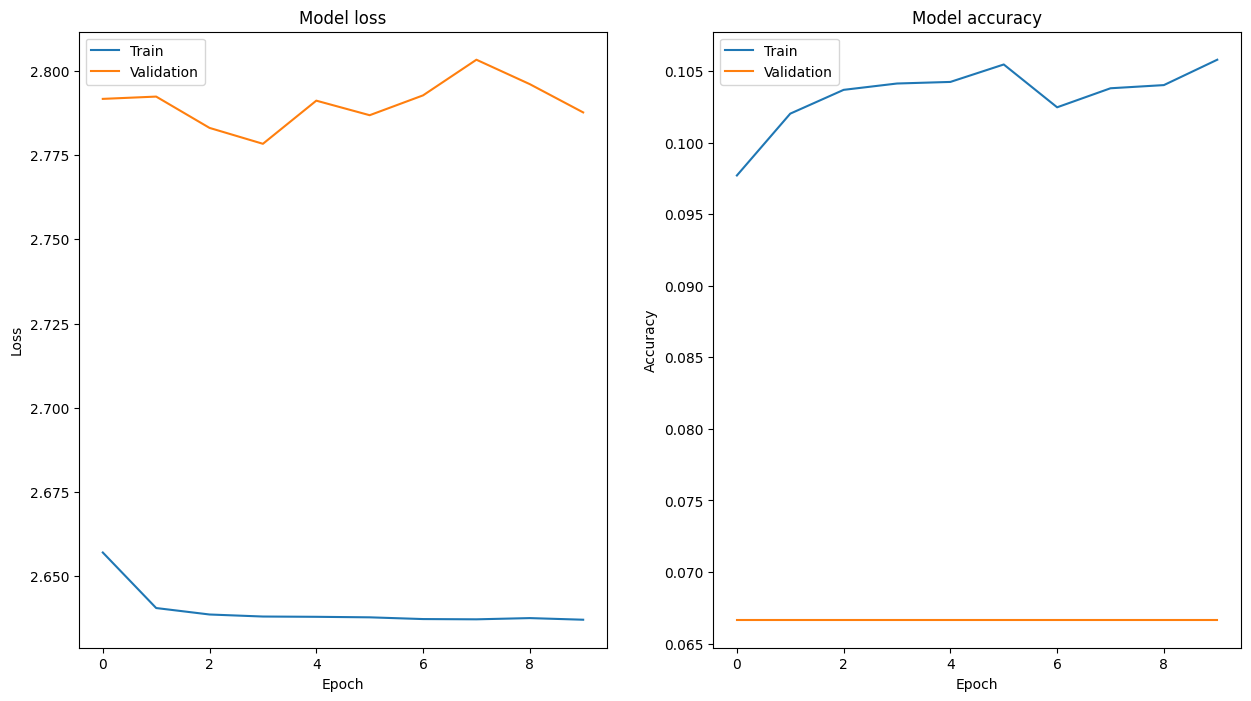

In [72]:
model = AlexNet(128)
model.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=10, batch_size=32, verbose=2, class_weight = weights)


scores = model.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['AlexNet', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

In [73]:
df128

Model  Train Accuracy  Validation Accuracy  Train Loss  \
0  Base 128 Model        0.983053             0.769667    0.056201   
1           LeNet        1.000000             0.704000    0.003637   
2         AlexNet        0.105782             0.066667    2.637107   

   Validation Loss                                            History  
0         1.291332  <keras.callbacks.History object at 0x000002976...  
1         1.203865  <keras.callbacks.History object at 0x000002976...  
2         2.787685  <keras.callbacks.History object at 0x000002978...

| Model            | Train Accuracy | Validation Accuracy | Train Loss | Validation Loss | Evaluation                                        |
| ---------------- | -------------- | ------------------- | ---------- | ---------------- | ------------------------------------------------- |
| Base 128 Model   | 98.28%         | 76.63%              | 0.05399    | 1.32059          | High accuracy, potential overfitting, check for regularization. |
| LeNet            | 98.90%         | 69.73%              | 0.10311    | 1.08369          | High accuracy, potential overfitting regularization might be good. |
| AlexNet          | 10.58%         | 6.67%               | 2.63660    | 2.79447          | Poor performance|


### Model Associated Improvements 

Recall the previous markdown involving methods of improving our models, we can now try to implement some of these



2. **Data Augmentation:**
   - **Description:** Data augmentation involves applying random transformations to the training data, such as rotation, scaling, and flipping. This increases the diversity of the training set, helping the model generalize better to different variations of the input data.
   - **Benefits:** Mitigates overfitting by exposing the model to a wider range of variations in the data.

3. **Batch Normalization:**
   - **Description:** Batch normalization normalizes the input of each layer in a neural network to have zero mean and unit variance. This can accelerate training, improve model stability, and reduce sensitivity to weight initialization.
   - **Benefits:** Enhances convergence speed and can make the model less dependent on the choice of hyperparameters.

4. **Learning Rate Scheduling:**
   - **Description:** Adjusting the learning rate during training can be beneficial. For example, starting with a higher learning rate and gradually reducing it as training progresses can help the model converge more effectively.
   - **Benefits:** Can improve convergence, prevent overshooting, and result in a more stable training process.

5. **Regularization Techniques:**
   - **Description:** Techniques like dropout, L1, and L2 regularization can be applied to prevent overfitting. Dropout randomly drops units during training, while L1 and L2 regularization penalize large weights.
   - **Benefits:** Helps the model generalize better to new data and reduces the risk of overfitting.

6. **Early Stopping:**
   - **Description:** Monitor the validation loss during training and stop training when the loss stops improving. This prevents overfitting and saves computational resources.
   - **Benefits:** Guards against overfitting and ensures the model is not trained for too many epochs.
   
7. **Adjusting Weights:**
   - **Description:** We can adjust the weights in order to account for the imbalanced distribution of the dataset.
   - **Benefits:** Helps address the issue of imbalanced classes by assigning higher weights to under-represented classes during training. This ensures that the model pays more attention to minority classes, improving overall predictive performance and reducing bias towards the majority class.


#### Adjusting Weights


We can easily calculate the weights for each class by dividing the total number of images by the number of images in each class. We can then use these weights to adjust the loss function during training.

```python

In [74]:
#calculate class weights for each label

train_class['weights'] = (1/train_class['count']) * (sum(train_class['count'])/len(train_data.class_names))
class_weight = train_class['weights'].to_dict()

#### Regularization Techniques for model 31

As we are not actually using the LeNet and AlexNet models, we will not be implementing the regularization techniques for them. However we will be implementing them for the base model in order to try and improve the performance of the model. As a bonus, we should also use the class weights that we previously computed in order to accomodate for the imbalanced dataset.

Epoch 1/100
283/283 - 2s - loss: 2.8984 - accuracy: 0.1614 - val_loss: 2.7004 - val_accuracy: 0.1493 - 2s/epoch - 8ms/step
Epoch 2/100
283/283 - 2s - loss: 2.3563 - accuracy: 0.2956 - val_loss: 2.1803 - val_accuracy: 0.3107 - 2s/epoch - 6ms/step
Epoch 3/100
283/283 - 2s - loss: 1.9923 - accuracy: 0.4010 - val_loss: 1.9031 - val_accuracy: 0.3893 - 2s/epoch - 6ms/step
Epoch 4/100
283/283 - 2s - loss: 1.6573 - accuracy: 0.5055 - val_loss: 1.4841 - val_accuracy: 0.5453 - 2s/epoch - 6ms/step
Epoch 5/100
283/283 - 2s - loss: 1.4511 - accuracy: 0.5682 - val_loss: 1.3594 - val_accuracy: 0.5900 - 2s/epoch - 6ms/step
Epoch 6/100
283/283 - 2s - loss: 1.2932 - accuracy: 0.6267 - val_loss: 1.3429 - val_accuracy: 0.5830 - 2s/epoch - 6ms/step
Epoch 7/100
283/283 - 2s - loss: 1.1900 - accuracy: 0.6542 - val_loss: 1.2535 - val_accuracy: 0.6173 - 2s/epoch - 6ms/step
Epoch 8/100
283/283 - 2s - loss: 1.0992 - accuracy: 0.6828 - val_loss: 1.3366 - val_accuracy: 0.5890 - 2s/epoch - 6ms/step
Epoch 9/100
283/

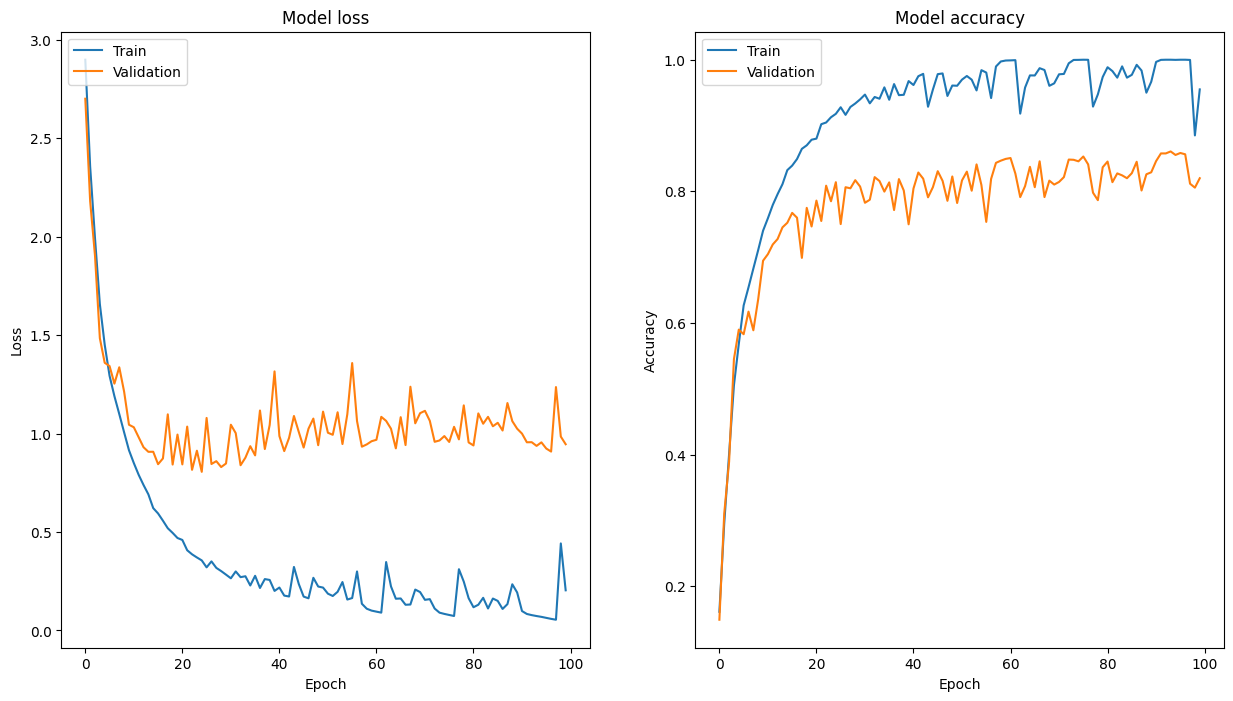

In [75]:
# model_31 = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(15, activation='softmax')
# ])

#this is the original "base model" that we used to overcome the overfitting we can apply regularization
# to improve teh accuracy we should also increase the number of epochs

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(15, activation='softmax')
])

model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight)

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['RegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

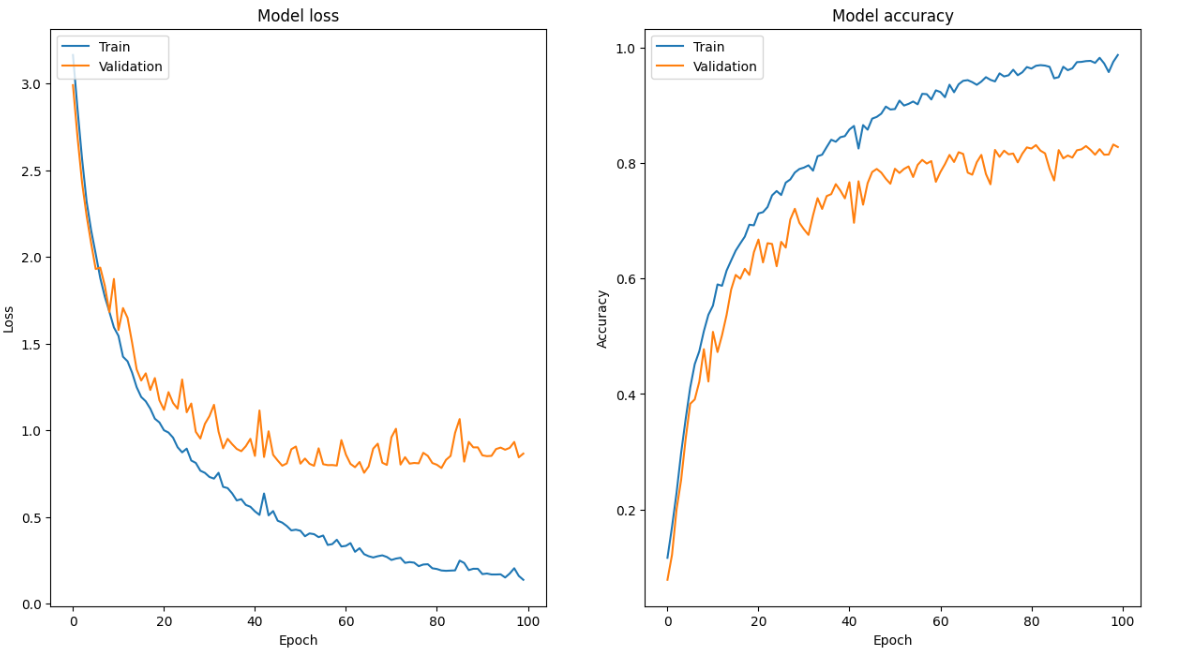

As seen from the graph, the learning of the model starts decreasing after around 30 epochs, we can try a learning rate scheduler to see if we can improve the performance of the model. As there is still some overfitting, we can also try to implement dropout in order to reduce the overfitting.

As the 31x31 images are simple, we will try not to overcomplicate the model for now and look for easier solutions to this problem.


Epoch 1/100
283/283 - 2s - loss: 3.0849 - accuracy: 0.1330 - val_loss: 2.6760 - val_accuracy: 0.1273 - 2s/epoch - 8ms/step
Epoch 2/100
283/283 - 2s - loss: 2.6246 - accuracy: 0.2305 - val_loss: 2.3195 - val_accuracy: 0.2313 - 2s/epoch - 6ms/step
Epoch 3/100
283/283 - 2s - loss: 2.3903 - accuracy: 0.2819 - val_loss: 2.3422 - val_accuracy: 0.2717 - 2s/epoch - 6ms/step
Epoch 4/100
283/283 - 2s - loss: 2.1883 - accuracy: 0.3367 - val_loss: 2.0453 - val_accuracy: 0.3380 - 2s/epoch - 6ms/step
Epoch 5/100
283/283 - 2s - loss: 2.0636 - accuracy: 0.3633 - val_loss: 1.9563 - val_accuracy: 0.3683 - 2s/epoch - 6ms/step
Epoch 6/100
283/283 - 2s - loss: 1.9621 - accuracy: 0.3874 - val_loss: 1.7724 - val_accuracy: 0.4167 - 2s/epoch - 6ms/step
Epoch 7/100
283/283 - 2s - loss: 1.8490 - accuracy: 0.4266 - val_loss: 1.8043 - val_accuracy: 0.4003 - 2s/epoch - 6ms/step
Epoch 8/100
283/283 - 2s - loss: 1.7801 - accuracy: 0.4425 - val_loss: 1.8623 - val_accuracy: 0.3903 - 2s/epoch - 6ms/step
Epoch 9/100
283/

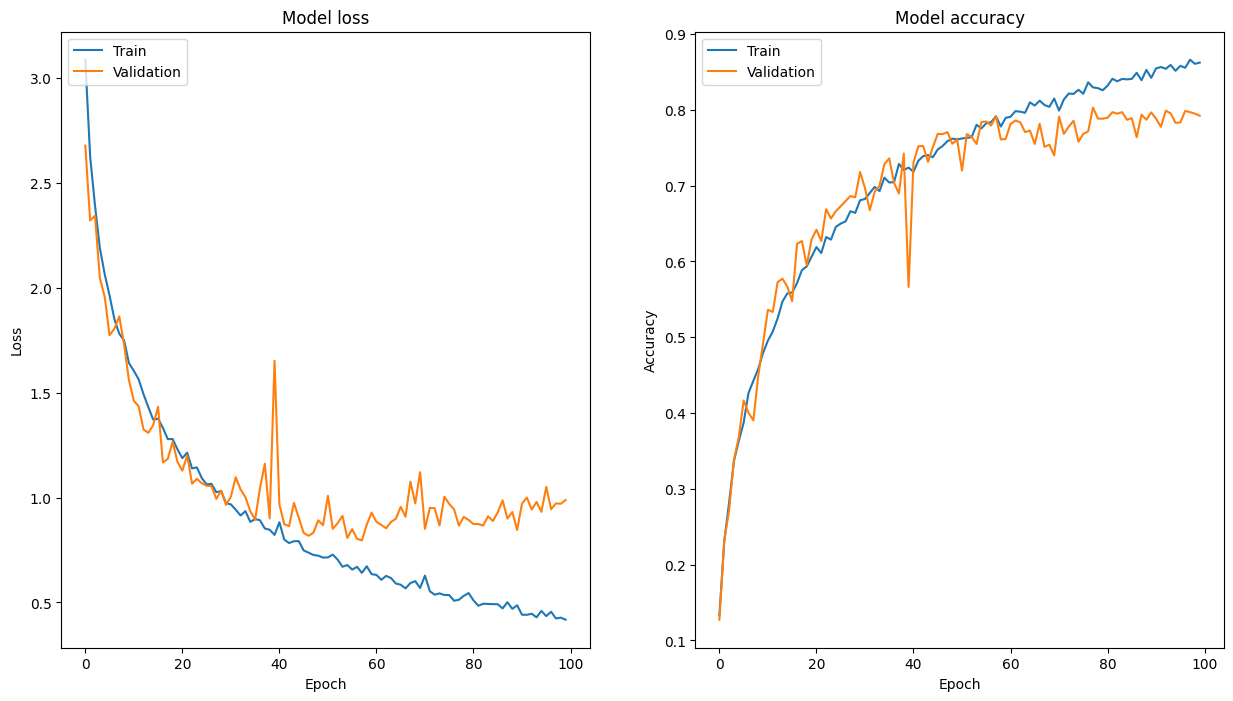

In [76]:
#First test with dropout


model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Add dropout with dropout rate of 0.5
    
    layers.Dense(15, activation='softmax')
])


model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight)

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['RegularizedDOModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

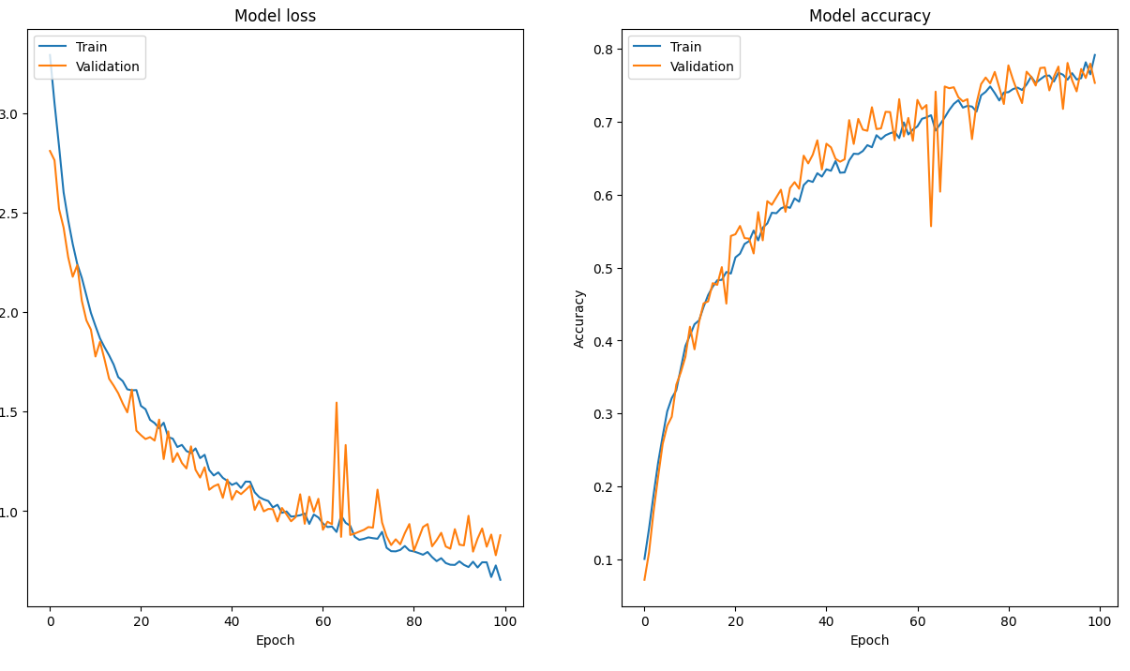


We can see that the overfitting problem is basically non existent now, we can try to increase the epochs to let the model fully converge and see if we can get better results.


Epoch 1/300
283/283 - 3s - loss: 3.1176 - accuracy: 0.1187 - val_loss: 2.7739 - val_accuracy: 0.0957 - 3s/epoch - 10ms/step
Epoch 2/300
283/283 - 2s - loss: 2.6738 - accuracy: 0.2205 - val_loss: 2.3789 - val_accuracy: 0.2030 - 2s/epoch - 6ms/step
Epoch 3/300
283/283 - 2s - loss: 2.4455 - accuracy: 0.2661 - val_loss: 2.3139 - val_accuracy: 0.2380 - 2s/epoch - 6ms/step
Epoch 4/300
283/283 - 2s - loss: 2.2854 - accuracy: 0.3126 - val_loss: 2.0454 - val_accuracy: 0.3427 - 2s/epoch - 6ms/step
Epoch 5/300
283/283 - 2s - loss: 2.1034 - accuracy: 0.3533 - val_loss: 1.9388 - val_accuracy: 0.3707 - 2s/epoch - 6ms/step
Epoch 6/300
283/283 - 2s - loss: 2.0105 - accuracy: 0.3775 - val_loss: 1.8100 - val_accuracy: 0.4027 - 2s/epoch - 6ms/step
Epoch 7/300
283/283 - 2s - loss: 1.8878 - accuracy: 0.4155 - val_loss: 1.7700 - val_accuracy: 0.4140 - 2s/epoch - 6ms/step
Epoch 8/300
283/283 - 2s - loss: 1.7992 - accuracy: 0.4361 - val_loss: 1.8100 - val_accuracy: 0.4163 - 2s/epoch - 6ms/step
Epoch 9/300
283

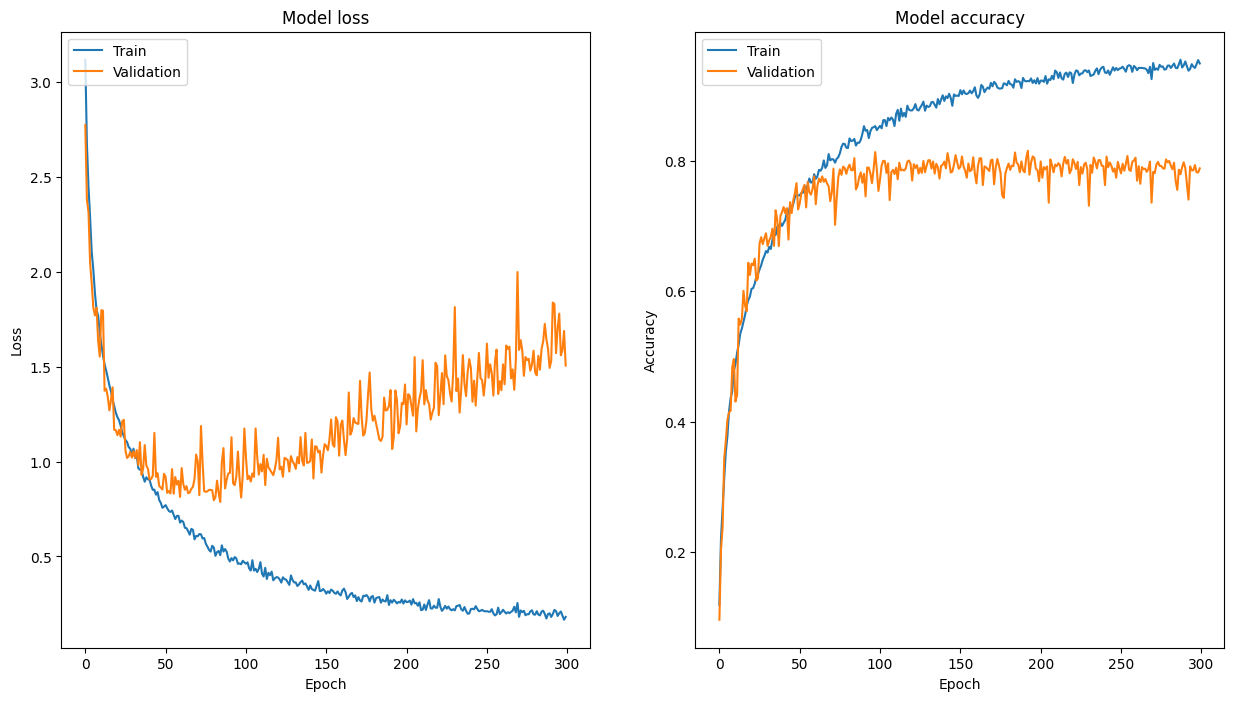

In [77]:
#Same model and other params, change epochs


model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5), 
    
    layers.Dense(15, activation='softmax')
])


model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=32, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['RegularizedDOModel2', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

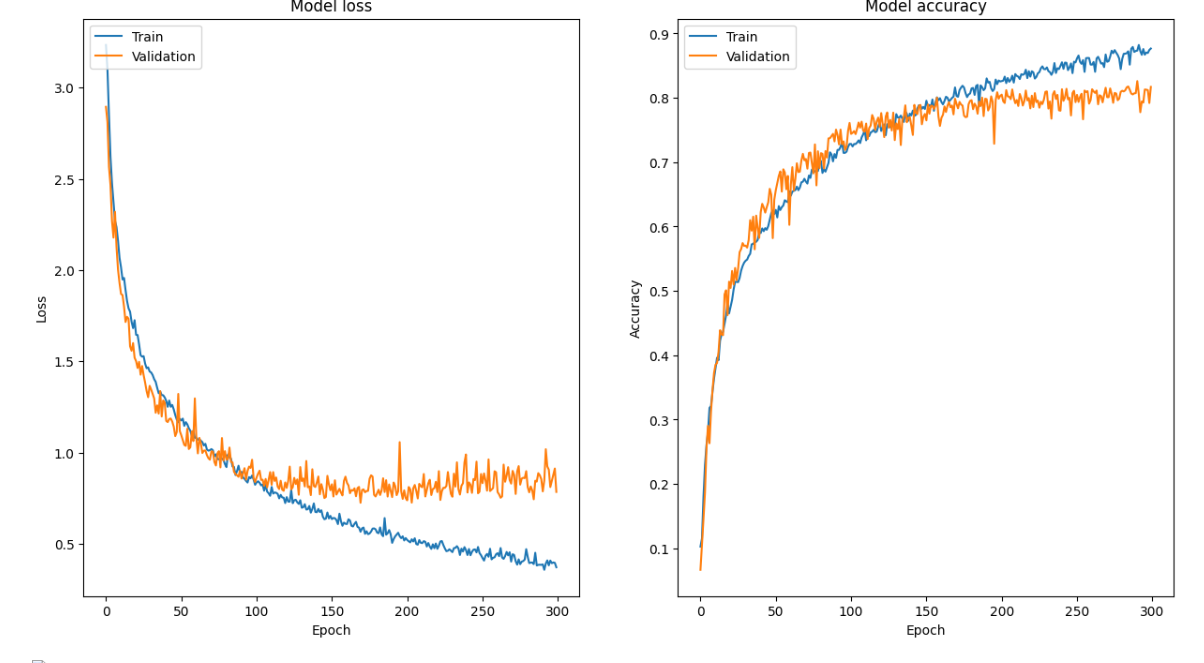

We can clearly see that the model stops learning and basically completely flattens out past around the 100th epoch, it is wise to either lower the learning rate of the model altogether or implement a learning rate scheduler in order to improve the performance of the model.

Epoch 1/300
283/283 - 2s - loss: 3.1245 - accuracy: 0.1214 - val_loss: 2.7308 - val_accuracy: 0.1137 - lr: 0.0010 - 2s/epoch - 8ms/step
Epoch 2/300
283/283 - 2s - loss: 2.6992 - accuracy: 0.2079 - val_loss: 2.4394 - val_accuracy: 0.1973 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/300
283/283 - 2s - loss: 2.4391 - accuracy: 0.2632 - val_loss: 2.3016 - val_accuracy: 0.2303 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 4/300
283/283 - 2s - loss: 2.2372 - accuracy: 0.3097 - val_loss: 2.0614 - val_accuracy: 0.3383 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 5/300
283/283 - 2s - loss: 2.0775 - accuracy: 0.3579 - val_loss: 1.9429 - val_accuracy: 0.3563 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 6/300
283/283 - 2s - loss: 1.9404 - accuracy: 0.3960 - val_loss: 1.7560 - val_accuracy: 0.4327 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 7/300
283/283 - 2s - loss: 1.8198 - accuracy: 0.4290 - val_loss: 1.7558 - val_accuracy: 0.4150 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 8/300
283/283 - 2s - loss: 1.7067 - accura

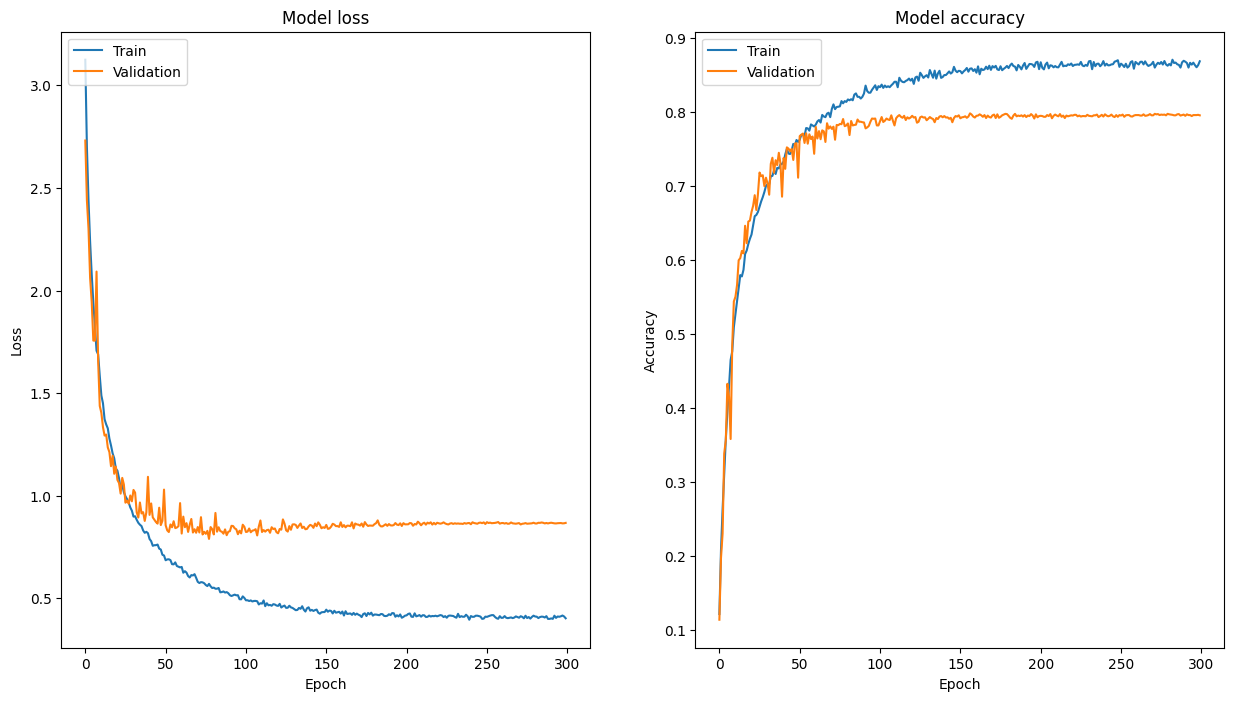

In [78]:
#try lr scheduler

def lr_schedule(epoch):
    initial_lr = 0.001 #default of adam
    decay_factor = 0.8
    epochs_drop = 10
    new_lr = initial_lr * (decay_factor ** (epoch // epochs_drop))
    return new_lr

lr_scheduler = LearningRateScheduler(lr_schedule)

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5), 
    
    layers.Dense(15, activation='softmax')
])


model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])
    
history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                          epochs=300, batch_size=32, verbose=2, class_weight=class_weight,
                          callbacks=[lr_scheduler])

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['LearningRateDecayModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]



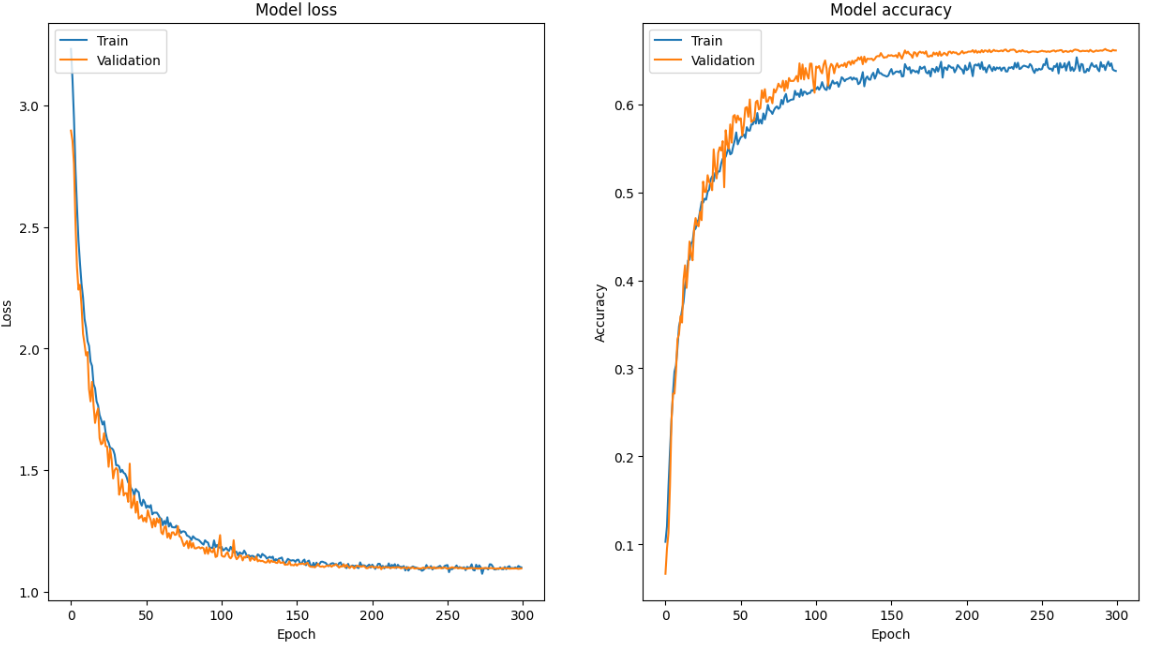
We can see that the learning rate scheduler has not improved the performance of the model, the accuracy is stll flattening out after about 100 epochs and the overall accuracy has decreased as well. Instead of using the learning rate scheduler, we can try to add more dropout layers/regularization layers to RegularizedDOModel2 (300 epoch model) and see if we can overcome the overfitting problem and get a val accuracy of over 90%.

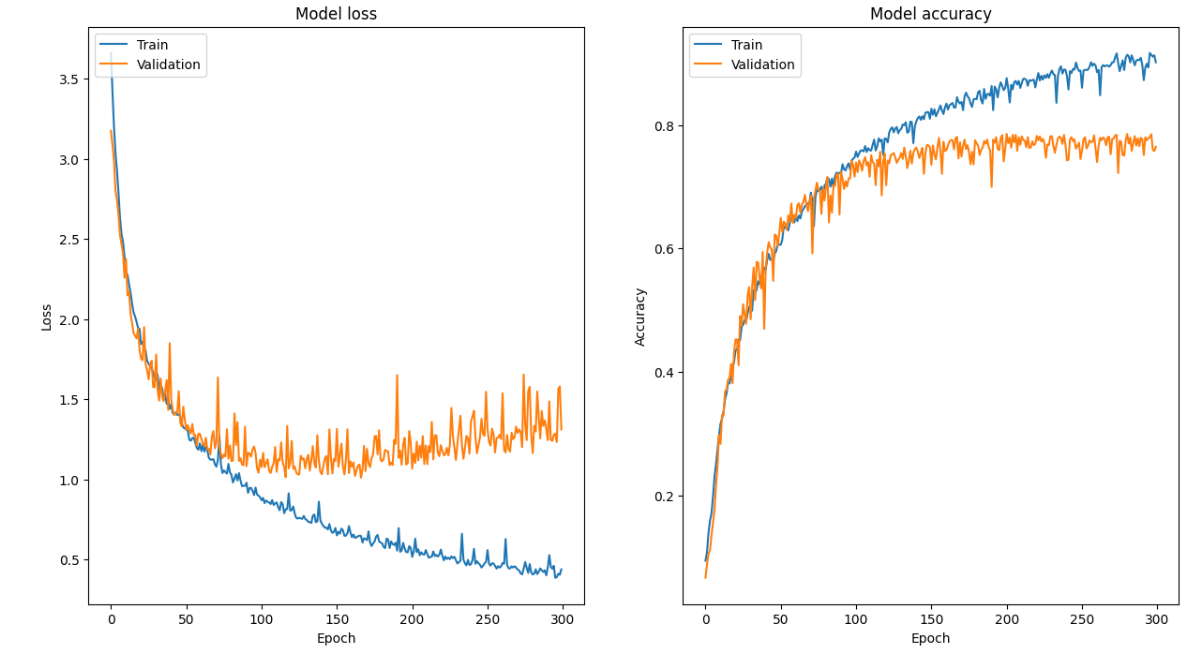

We can see that the model is still overfitting, and that it has actually gotten worse. Because of this i feel like i should change my direction of approach. We can try to remove some of the layers in model and see if we can get better results.

Epoch 1/300
283/283 - 2s - loss: 3.1092 - accuracy: 0.1311 - val_loss: 2.7495 - val_accuracy: 0.1113 - 2s/epoch - 8ms/step
Epoch 2/300
283/283 - 2s - loss: 2.7414 - accuracy: 0.2068 - val_loss: 2.5124 - val_accuracy: 0.1923 - 2s/epoch - 6ms/step
Epoch 3/300
283/283 - 2s - loss: 2.4760 - accuracy: 0.2654 - val_loss: 2.3887 - val_accuracy: 0.2097 - 2s/epoch - 6ms/step
Epoch 4/300
283/283 - 2s - loss: 2.2711 - accuracy: 0.3082 - val_loss: 2.1316 - val_accuracy: 0.3063 - 2s/epoch - 6ms/step
Epoch 5/300
283/283 - 2s - loss: 2.1107 - accuracy: 0.3467 - val_loss: 1.9534 - val_accuracy: 0.3523 - 2s/epoch - 6ms/step
Epoch 6/300
283/283 - 2s - loss: 2.0365 - accuracy: 0.3626 - val_loss: 1.8242 - val_accuracy: 0.4083 - 2s/epoch - 6ms/step
Epoch 7/300
283/283 - 2s - loss: 1.9024 - accuracy: 0.4026 - val_loss: 1.8550 - val_accuracy: 0.3857 - 2s/epoch - 6ms/step
Epoch 8/300
283/283 - 2s - loss: 1.8355 - accuracy: 0.4175 - val_loss: 1.7458 - val_accuracy: 0.4240 - 2s/epoch - 6ms/step
Epoch 9/300
283/

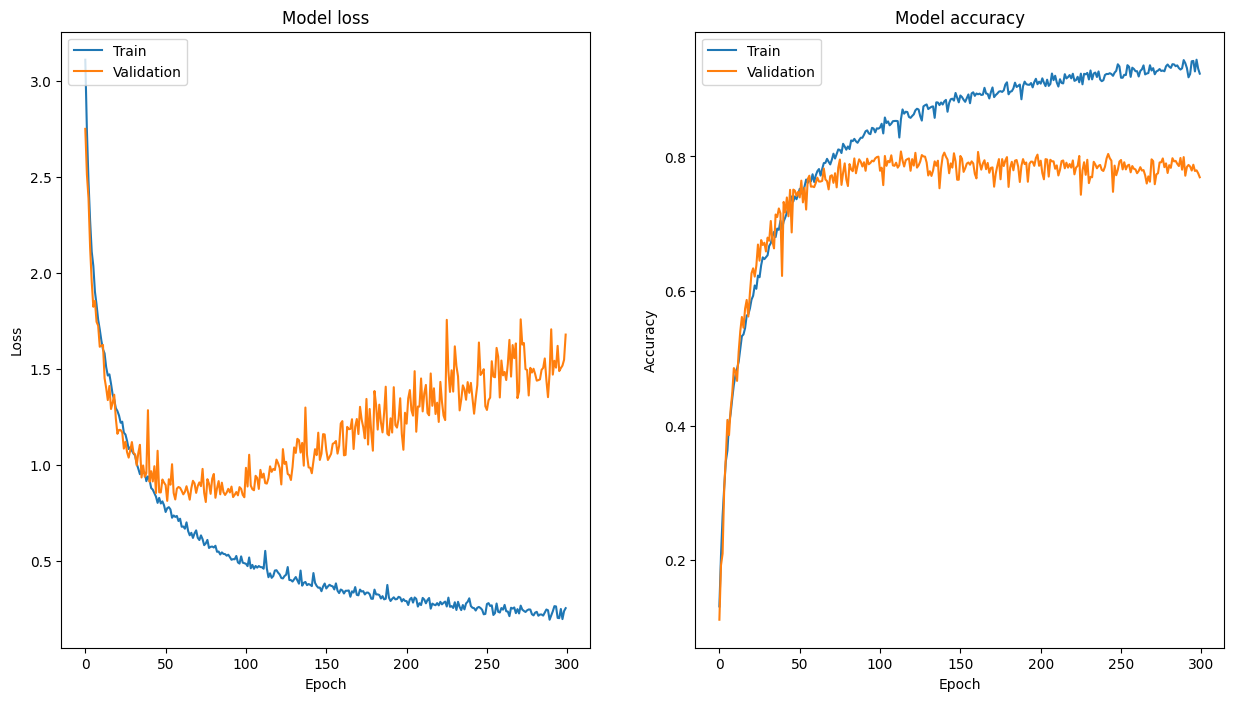

In [79]:
#Decrease layers

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=32, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['LessLayersRegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

Epoch 1/300
283/283 - 3s - loss: 3.4039 - accuracy: 0.0982 - val_loss: 2.9206 - val_accuracy: 0.0667 - 3s/epoch - 9ms/step
Epoch 2/300
283/283 - 2s - loss: 3.0334 - accuracy: 0.1571 - val_loss: 2.7849 - val_accuracy: 0.1183 - 2s/epoch - 7ms/step
Epoch 3/300
283/283 - 2s - loss: 2.8069 - accuracy: 0.1883 - val_loss: 2.6983 - val_accuracy: 0.1600 - 2s/epoch - 7ms/step
Epoch 4/300
283/283 - 2s - loss: 2.6429 - accuracy: 0.2265 - val_loss: 2.4743 - val_accuracy: 0.2067 - 2s/epoch - 7ms/step
Epoch 5/300
283/283 - 2s - loss: 2.5211 - accuracy: 0.2512 - val_loss: 2.3884 - val_accuracy: 0.2367 - 2s/epoch - 7ms/step
Epoch 6/300
283/283 - 2s - loss: 2.3987 - accuracy: 0.2777 - val_loss: 2.2960 - val_accuracy: 0.2690 - 2s/epoch - 7ms/step
Epoch 7/300
283/283 - 2s - loss: 2.2968 - accuracy: 0.3075 - val_loss: 2.2063 - val_accuracy: 0.3023 - 2s/epoch - 7ms/step
Epoch 8/300
283/283 - 2s - loss: 2.1650 - accuracy: 0.3439 - val_loss: 2.1594 - val_accuracy: 0.3507 - 2s/epoch - 7ms/step
Epoch 9/300
283/

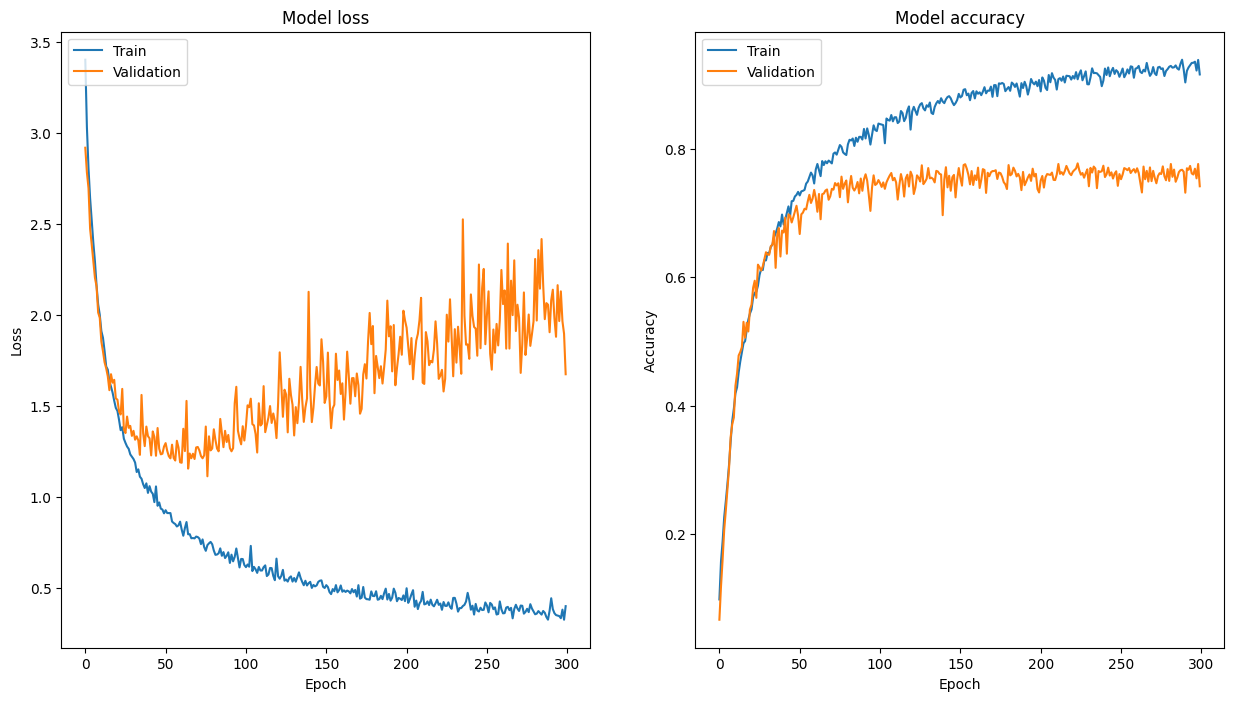

In [80]:
#Increase dropout layers and l1 regularization instead

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=32, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['ExtraDORegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

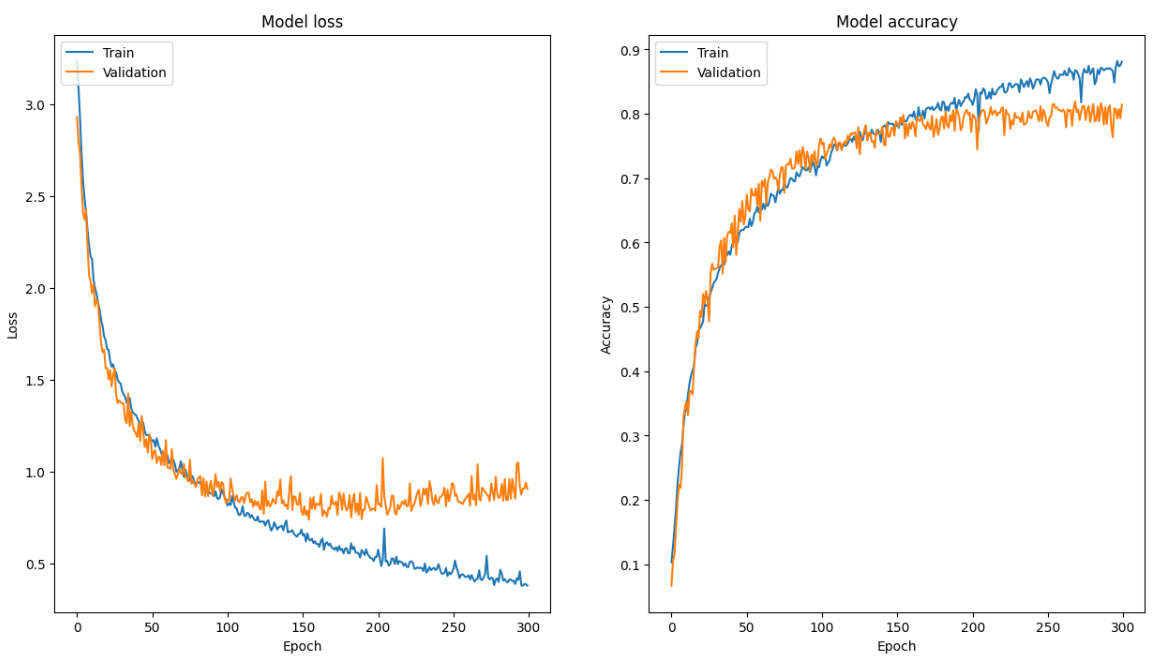



We can see that the performance has improved ever so slightly, we can consider adding dropouts to the con layers to close up the overfitting gap.

Epoch 1/300
46/46 - 1s - loss: 3.2680 - accuracy: 0.0981 - val_loss: 2.8407 - val_accuracy: 0.0667 - 1s/epoch - 22ms/step
Epoch 2/300
46/46 - 0s - loss: 3.1172 - accuracy: 0.1257 - val_loss: 2.7823 - val_accuracy: 0.1057 - 411ms/epoch - 9ms/step
Epoch 3/300
46/46 - 0s - loss: 2.9492 - accuracy: 0.1653 - val_loss: 2.6585 - val_accuracy: 0.1163 - 375ms/epoch - 8ms/step
Epoch 4/300
46/46 - 0s - loss: 2.6901 - accuracy: 0.2091 - val_loss: 2.3801 - val_accuracy: 0.2100 - 351ms/epoch - 8ms/step
Epoch 5/300
46/46 - 0s - loss: 2.5047 - accuracy: 0.2467 - val_loss: 2.2451 - val_accuracy: 0.2627 - 361ms/epoch - 8ms/step
Epoch 6/300
46/46 - 0s - loss: 2.3526 - accuracy: 0.2846 - val_loss: 2.1650 - val_accuracy: 0.2927 - 365ms/epoch - 8ms/step
Epoch 7/300
46/46 - 0s - loss: 2.2649 - accuracy: 0.3093 - val_loss: 2.1413 - val_accuracy: 0.3133 - 345ms/epoch - 8ms/step
Epoch 8/300
46/46 - 0s - loss: 2.1591 - accuracy: 0.3382 - val_loss: 1.9584 - val_accuracy: 0.3720 - 366ms/epoch - 8ms/step
Epoch 9/30

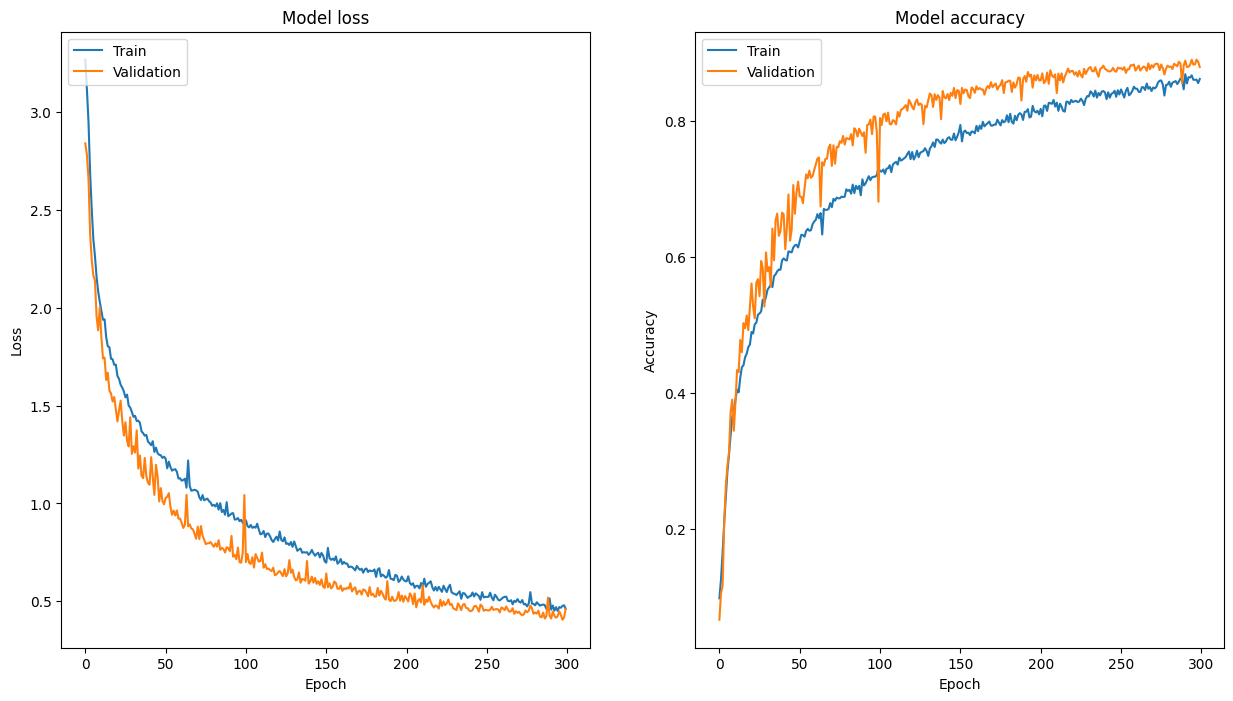

In [81]:
#Increase dropout

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['ExtraRegularReducedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

In [82]:
model_31new.save('extraregularized31.h5')

Epoch 1/100
283/283 - 2s - loss: 2.4288 - accuracy: 0.1907 - val_loss: 2.1557 - val_accuracy: 0.3240 - 2s/epoch - 8ms/step
Epoch 2/100
283/283 - 2s - loss: 1.8260 - accuracy: 0.4176 - val_loss: 1.6735 - val_accuracy: 0.4660 - 2s/epoch - 6ms/step
Epoch 3/100
283/283 - 2s - loss: 1.4699 - accuracy: 0.5313 - val_loss: 1.4576 - val_accuracy: 0.5240 - 2s/epoch - 6ms/step
Epoch 4/100
283/283 - 2s - loss: 1.2159 - accuracy: 0.6068 - val_loss: 1.3170 - val_accuracy: 0.5620 - 2s/epoch - 6ms/step
Epoch 5/100
283/283 - 2s - loss: 1.0197 - accuracy: 0.6720 - val_loss: 1.0598 - val_accuracy: 0.6637 - 2s/epoch - 6ms/step
Epoch 6/100
283/283 - 2s - loss: 0.9039 - accuracy: 0.7111 - val_loss: 0.9845 - val_accuracy: 0.6873 - 2s/epoch - 6ms/step
Epoch 7/100
283/283 - 2s - loss: 0.7979 - accuracy: 0.7466 - val_loss: 0.9231 - val_accuracy: 0.7053 - 2s/epoch - 6ms/step
Epoch 8/100
283/283 - 2s - loss: 0.6889 - accuracy: 0.7817 - val_loss: 0.8769 - val_accuracy: 0.7227 - 2s/epoch - 6ms/step
Epoch 9/100
283/

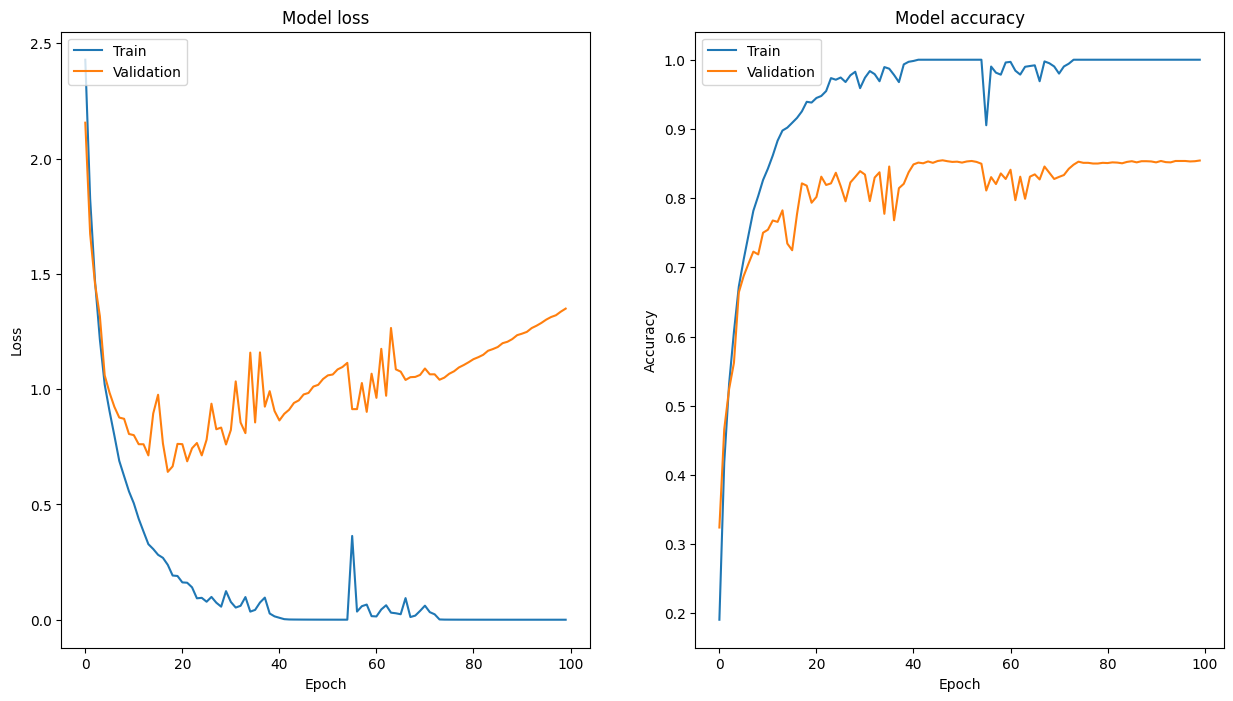

In [83]:
model_31 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_31.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_31.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=100, batch_size=32, verbose=2, class_weight = weights)
scores = model_31.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['Base 31 Model 100 epoch', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


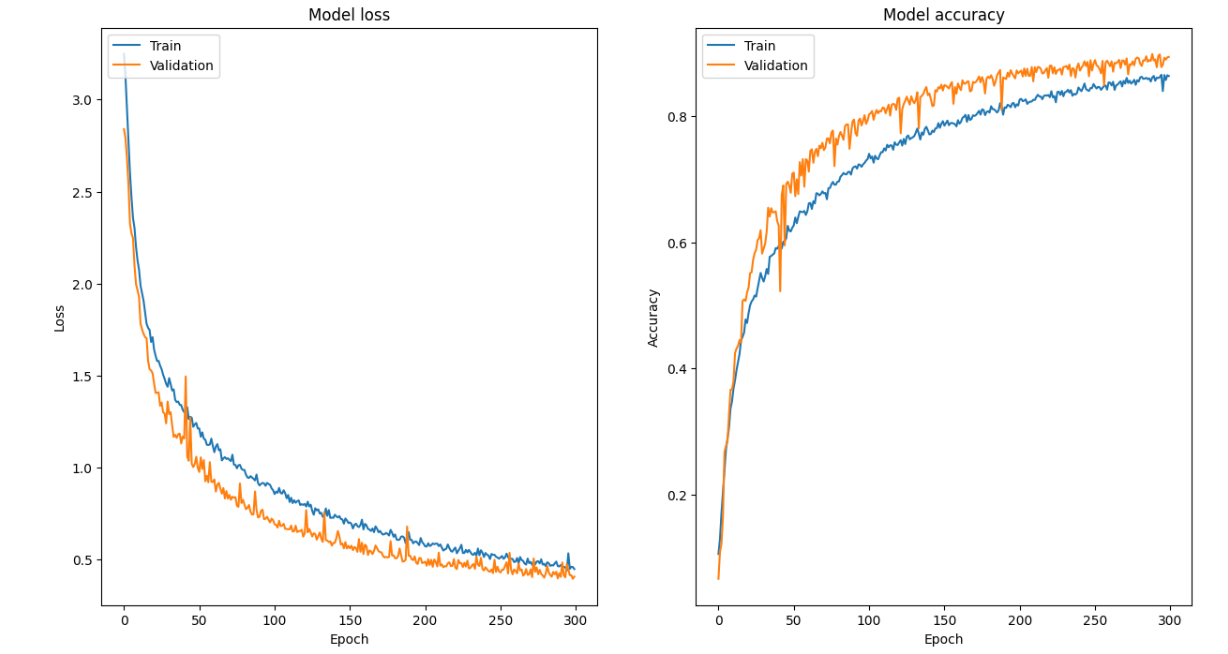



We can see that the model's performance now is excellent, we can see that near the end of the 300 epochs, there is still some sort of increase in accuracy, we can try to increase the epochs to 500 and see if we can get better results. However this is not a good idea as the runtime will increase by a lot for a small increase in accuracy, instead we can try to implement batch normalization for quicker convergence.

Epoch 1/300
46/46 - 1s - loss: 3.4306 - accuracy: 0.1027 - val_loss: 2.7976 - val_accuracy: 0.0677 - 1s/epoch - 26ms/step
Epoch 2/300
46/46 - 0s - loss: 2.9441 - accuracy: 0.2012 - val_loss: 2.7892 - val_accuracy: 0.1160 - 418ms/epoch - 9ms/step
Epoch 3/300
46/46 - 0s - loss: 2.6536 - accuracy: 0.2453 - val_loss: 2.7710 - val_accuracy: 0.1247 - 395ms/epoch - 9ms/step
Epoch 4/300
46/46 - 0s - loss: 2.4595 - accuracy: 0.2790 - val_loss: 2.7231 - val_accuracy: 0.1307 - 390ms/epoch - 8ms/step
Epoch 5/300
46/46 - 0s - loss: 2.3092 - accuracy: 0.3137 - val_loss: 2.6553 - val_accuracy: 0.1403 - 392ms/epoch - 9ms/step
Epoch 6/300
46/46 - 0s - loss: 2.1286 - accuracy: 0.3597 - val_loss: 2.5549 - val_accuracy: 0.1593 - 383ms/epoch - 8ms/step
Epoch 7/300
46/46 - 0s - loss: 1.9885 - accuracy: 0.3954 - val_loss: 2.3986 - val_accuracy: 0.2450 - 384ms/epoch - 8ms/step
Epoch 8/300
46/46 - 0s - loss: 1.9001 - accuracy: 0.4205 - val_loss: 2.2704 - val_accuracy: 0.2840 - 399ms/epoch - 9ms/step
Epoch 9/30

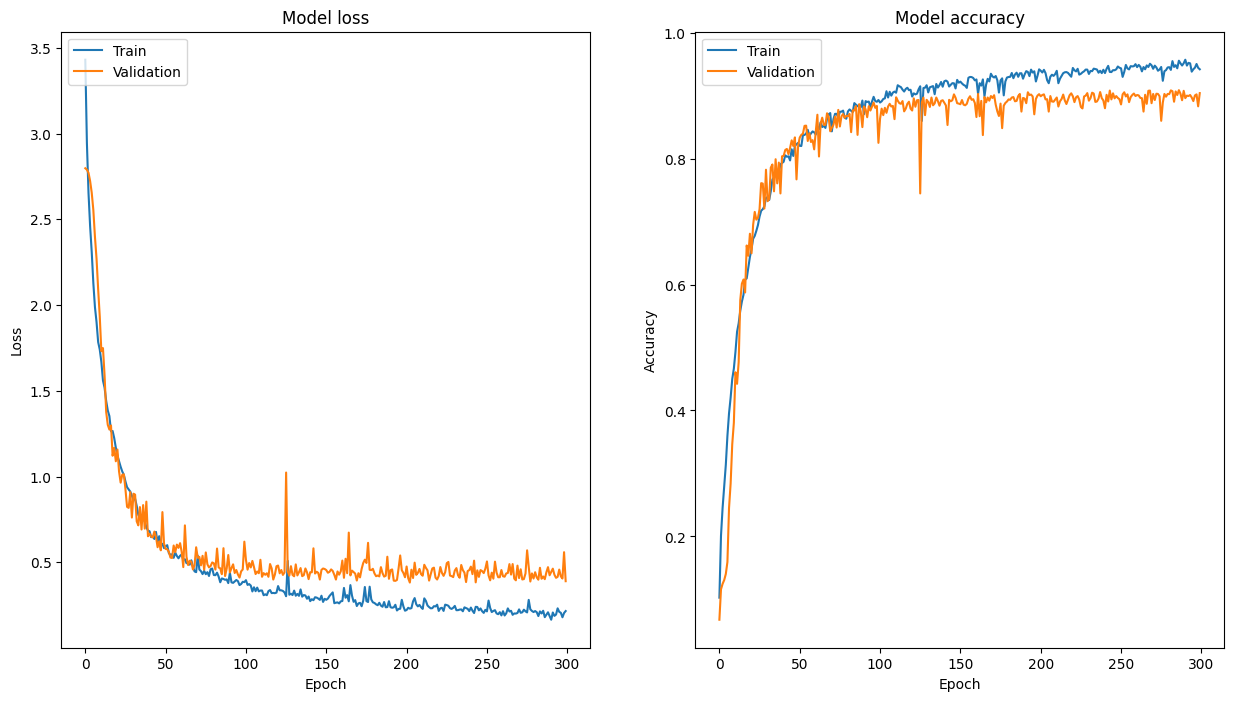

In [84]:
#Batch normalization

model_31new = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.BatchNormalization(),
    layers.Dense(15, activation='softmax')
])



model_31new.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31new.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31new.evaluate(X_val31, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['NormalizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

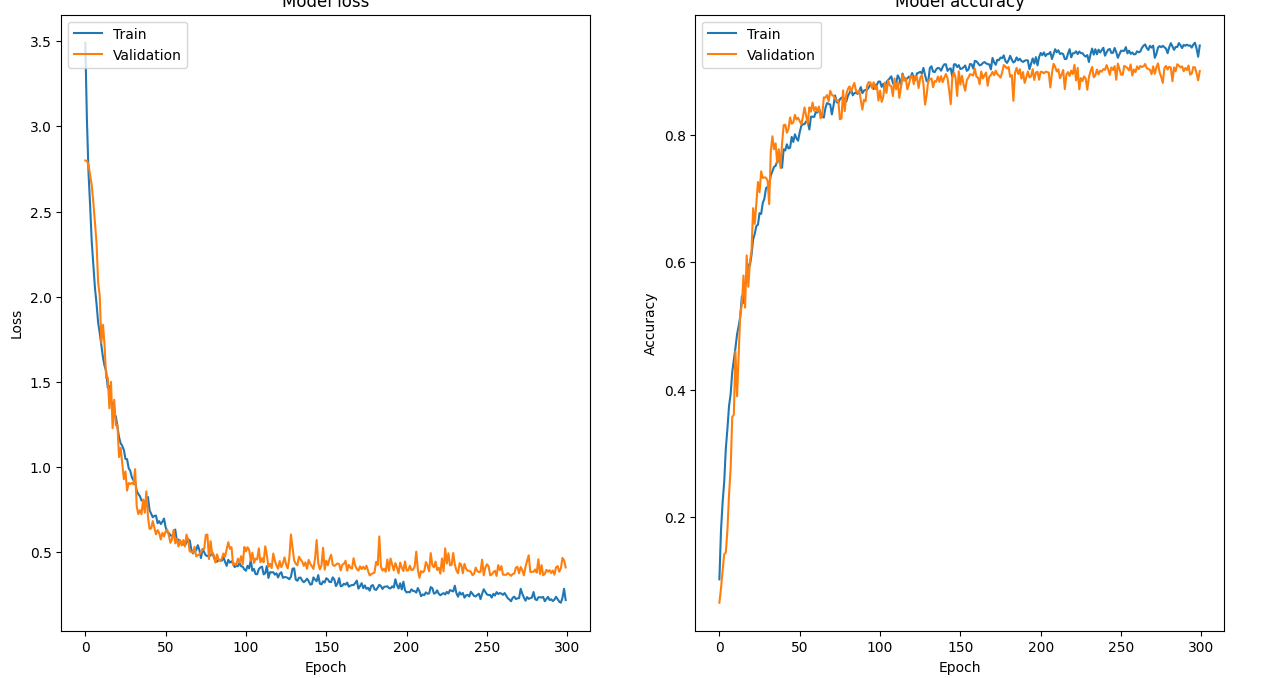



We can see that the model is being fitted very well with a high accuracy (over 90%) as well as there not being much overfitting. This a massive improvement from the original model, which can be seen below


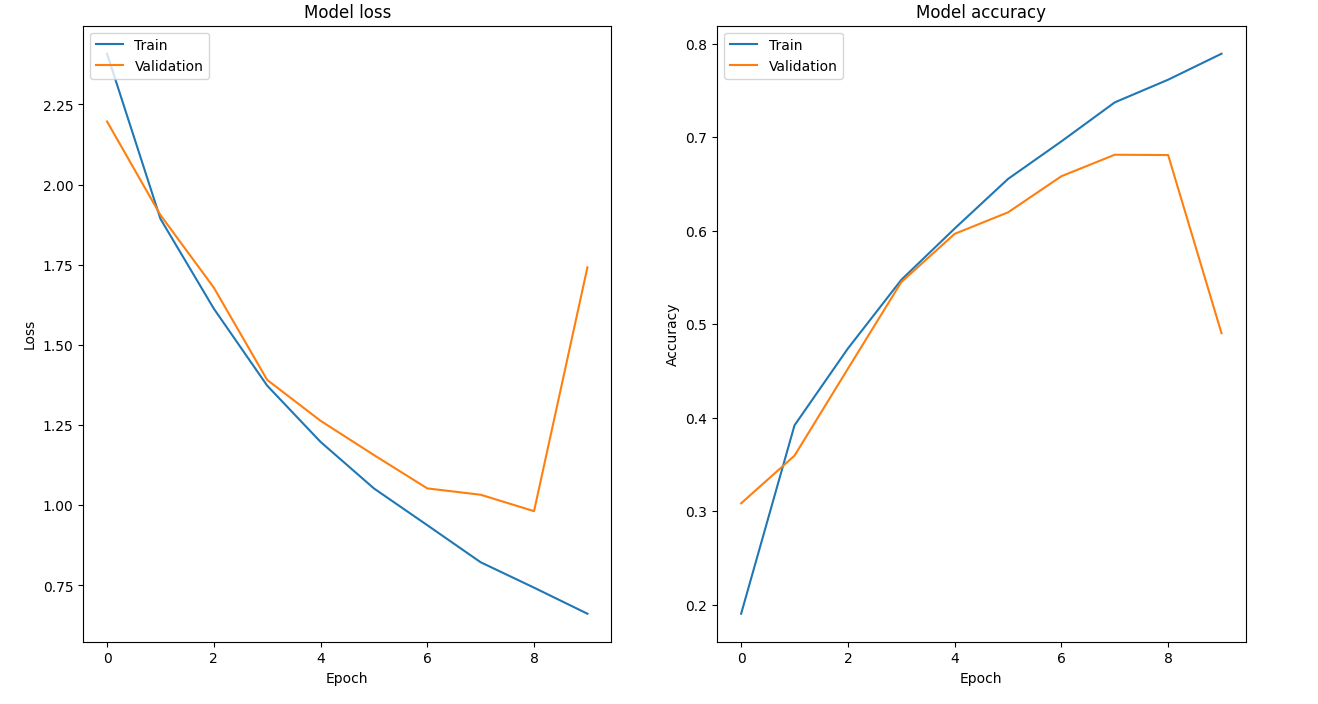

Epoch 1/100
283/283 - 2s - loss: 2.4328 - accuracy: 0.1823 - val_loss: 2.2299 - val_accuracy: 0.2573 - 2s/epoch - 8ms/step
Epoch 2/100
283/283 - 2s - loss: 1.8061 - accuracy: 0.4108 - val_loss: 1.6133 - val_accuracy: 0.4843 - 2s/epoch - 6ms/step
Epoch 3/100
283/283 - 2s - loss: 1.4227 - accuracy: 0.5423 - val_loss: 1.6551 - val_accuracy: 0.4590 - 2s/epoch - 6ms/step
Epoch 4/100
283/283 - 2s - loss: 1.1772 - accuracy: 0.6175 - val_loss: 1.1525 - val_accuracy: 0.6220 - 2s/epoch - 6ms/step
Epoch 5/100
283/283 - 2s - loss: 1.0069 - accuracy: 0.6747 - val_loss: 1.1287 - val_accuracy: 0.6333 - 2s/epoch - 6ms/step
Epoch 6/100
283/283 - 2s - loss: 0.8924 - accuracy: 0.7129 - val_loss: 0.9572 - val_accuracy: 0.6823 - 2s/epoch - 6ms/step
Epoch 7/100
283/283 - 2s - loss: 0.8108 - accuracy: 0.7380 - val_loss: 0.9208 - val_accuracy: 0.6930 - 2s/epoch - 6ms/step
Epoch 8/100
283/283 - 2s - loss: 0.6937 - accuracy: 0.7791 - val_loss: 0.9334 - val_accuracy: 0.6917 - 2s/epoch - 6ms/step
Epoch 9/100
283/

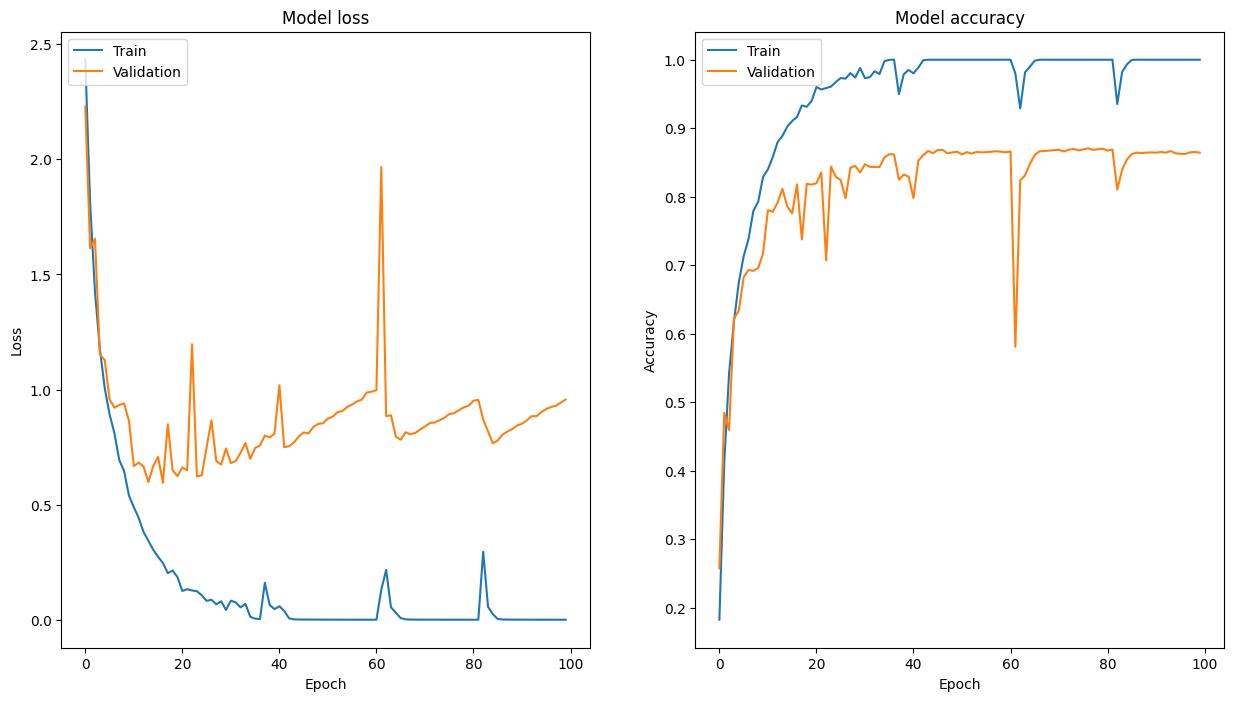

In [85]:
model_31base100epoch = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_31base100epoch.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_31base100epoch.fit(X_train31, train_labels, validation_data=(X_val31, validation_labels),
 epochs=100, batch_size=32, verbose=2, class_weight = weights)
scores = model_31base100epoch.evaluate(X_val31, validation_labels, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31.loc[len(df31)] = ['Base 31 Model 100 epochs', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


In [86]:
model_31new.save('Goat31Model.h5')

In [87]:
df31

Model Name  Train Accuracy  Validation Accuracy  \
0                Base 31 Model        0.791094             0.663667   
1                        LeNet        0.730394             0.568667   
2                      AlexNet        0.105782             0.066667   
3             RegularizedModel        0.954918             0.820000   
4           RegularizedDOModel        0.862428             0.792333   
5          RegularizedDOModel2        0.949712             0.788667   
6       LearningRateDecayModel        0.868742             0.795667   
7   LessLayersRegularizedModel        0.923017             0.769000   
8      ExtraDORegularizedModel        0.915374             0.741333   
9     ExtraRegularReducedModel        0.860988             0.878667   
10     Base 31 Model 100 epoch        1.000000             0.854333   
11             NormalizedModel        0.941848             0.904000   
12    Base 31 Model 100 epochs        1.000000             0.864333   

    Train Loss  Validation Loss  \
0     0.658891         1.048594   
1     0.879061         1.343069   
2     2.637136         2.785906   
3     0.204025         0.945825   
4     0.417925         0.987717   
5     0.180752         1.505520   
6     0.402974         0.867698   
7     0.256261         1.679431   
8     0.402334         1.676261   
9     0.461189         0.461075   
10    0.000011         1.349309   
11    0.215342         0.389454   
12    0.000088         0.956402   

                                              History  
0   <keras.callbacks.History object at 0x00000292A...  
1   <keras.callbacks.History object at 0x000002976...  
2   <keras.callbacks.History object at 0x000002978...  
3   <keras.callbacks.History object at 0x000002976...  
4   <keras.callbacks.History object at 0x000002976...  
5   <keras.callbacks.History object at 0x000002976...  
6   <keras.callbacks.History object at 0x000002978...  
7   <keras.callbacks.History object at 0x000002979...  
8   <keras.callbacks.History object at 0x000002977...  
9   <keras.callbacks.History object at 0x000002976...  
10  <keras.callbacks.History object at 0x000002976...  
11  <keras.callbacks.History object at 0x000002977...  
12  <keras.callbacks.History object at 0x000002977...

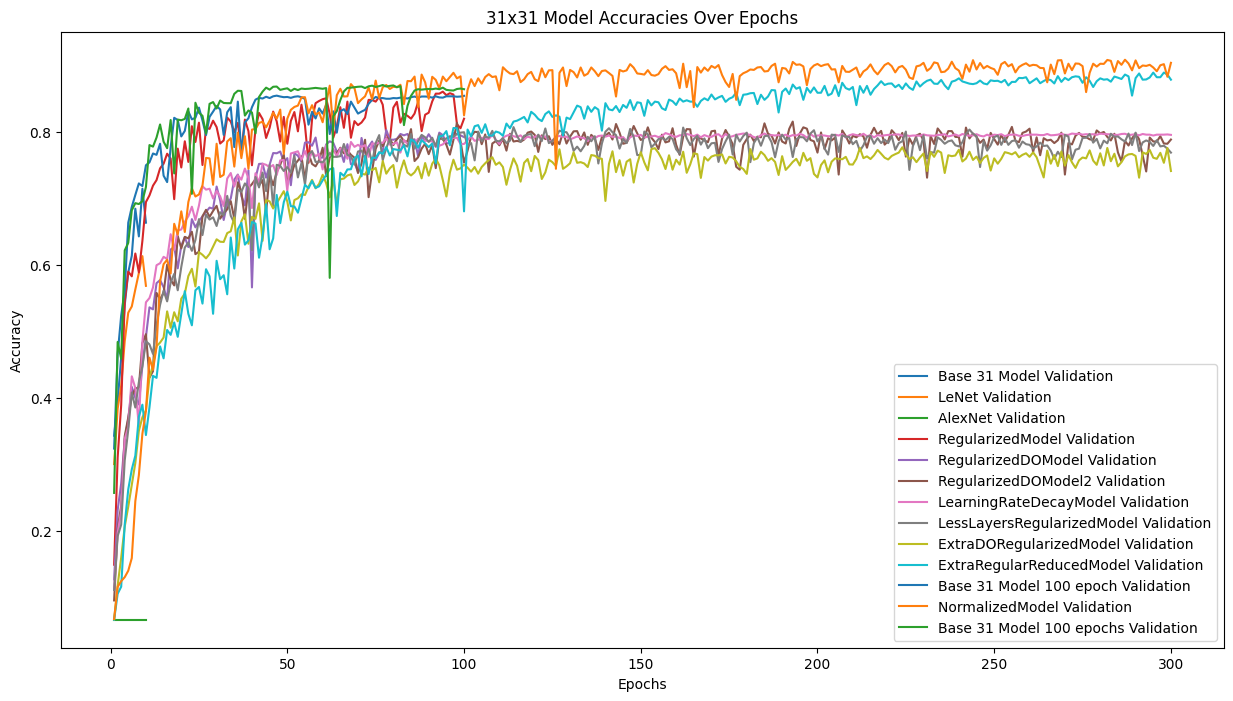

In [88]:
plt.figure(figsize=(15, 8))

for index, row in df31[['Model Name', 'History']].iterrows():
    model_name = row['Model Name']
    history = row['History']
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label=f'{model_name} Validation')

plt.title('31x31 Model Accuracies Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


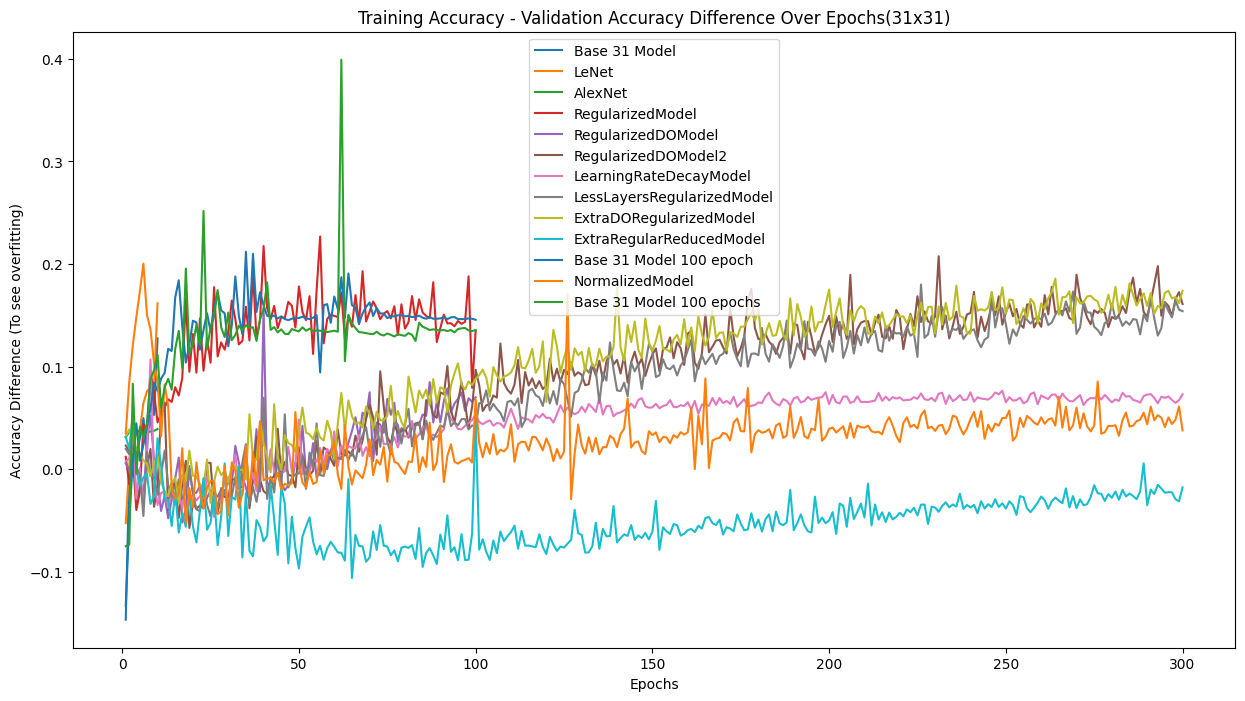

In [89]:
plt.figure(figsize=(15, 8))

for index, row in df31[['Model Name', 'History']].iterrows():
    model_name = row['Model Name']
    history = row['History']

    accuracy_diff = [train_acc - val_acc for train_acc, val_acc in zip(history.history['accuracy'], history.history['val_accuracy'])]

    sns.lineplot(x=range(1, len(accuracy_diff) + 1), y=accuracy_diff, label=f'{model_name}')

plt.title('Training Accuracy - Validation Accuracy Difference Over Epochs(31x31)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference (To see overfitting)')

plt.legend()

plt.show()


#### Graphs Evaluation


As we can see, the model with the least overfitting is the model with increased dropout layers as well as the model with batch normalization. If we are looking at which model has the most consistent performance, it can be said that the model with batch normalization is the best, from the val accuracy graph, we can also see that the model with batch normalization has the highest val accuracy and converges faster. However before we make our final judgement we can test both models on the test set and see which model performs better.

In [90]:
#convert tets to 31x31 
X_test_resized = tf.image.resize(X_test, (31, 31))
X_test31 = X_test_resized.numpy().reshape(X_test_resized.shape[0], 31, 31, 1).astype('float32') / 255
test_labels = to_categorical(y_test)

Epoch 1/300
46/46 - 1s - loss: 3.4656 - accuracy: 0.1027 - val_loss: 2.7961 - val_accuracy: 0.0670 - 1s/epoch - 26ms/step
Epoch 2/300
46/46 - 0s - loss: 3.0487 - accuracy: 0.1737 - val_loss: 2.8050 - val_accuracy: 0.1137 - 415ms/epoch - 9ms/step
Epoch 3/300
46/46 - 0s - loss: 2.7933 - accuracy: 0.2129 - val_loss: 2.8078 - val_accuracy: 0.1200 - 403ms/epoch - 9ms/step
Epoch 4/300
46/46 - 0s - loss: 2.5543 - accuracy: 0.2480 - val_loss: 2.7453 - val_accuracy: 0.1253 - 402ms/epoch - 9ms/step
Epoch 5/300
46/46 - 0s - loss: 2.4387 - accuracy: 0.2748 - val_loss: 2.6911 - val_accuracy: 0.1477 - 405ms/epoch - 9ms/step
Epoch 6/300
46/46 - 0s - loss: 2.2895 - accuracy: 0.3085 - val_loss: 2.5898 - val_accuracy: 0.1727 - 424ms/epoch - 9ms/step
Epoch 7/300
46/46 - 0s - loss: 2.1581 - accuracy: 0.3405 - val_loss: 2.4581 - val_accuracy: 0.1983 - 390ms/epoch - 8ms/step
Epoch 8/300
46/46 - 0s - loss: 2.0571 - accuracy: 0.3661 - val_loss: 2.3478 - val_accuracy: 0.2797 - 387ms/epoch - 8ms/step
Epoch 9/30

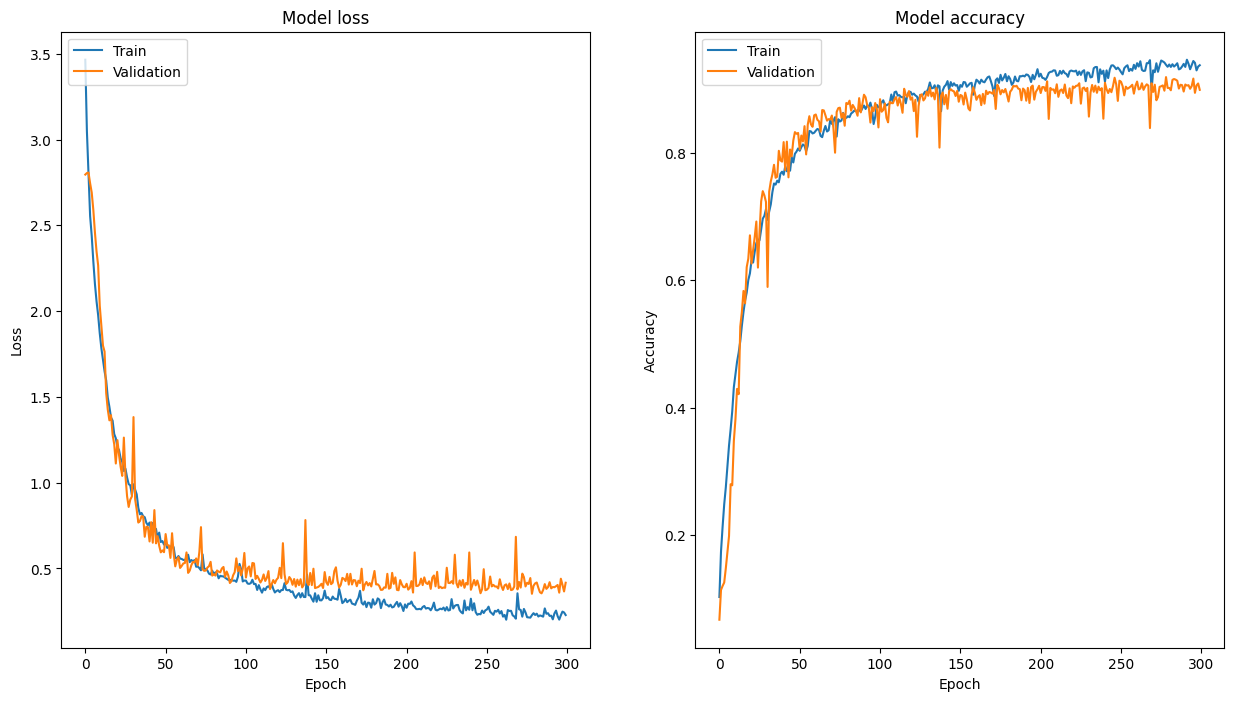

In [91]:
##batch normalization model
df31final = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'test Accuracy', 'Train Loss', 'test Loss', 'History'])

model_31bn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.BatchNormalization(),
    layers.Dense(15, activation='softmax')
])

model_31bn.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31bn.fit(X_train31, train_labels, validation_data=(X_test31, test_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31bn.evaluate(X_test31, test_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31final.loc[len(df31final)] = ['NormalizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


Epoch 1/300
46/46 - 1s - loss: 3.2791 - accuracy: 0.0969 - val_loss: 2.8517 - val_accuracy: 0.0667 - 985ms/epoch - 21ms/step
Epoch 2/300
46/46 - 0s - loss: 3.1497 - accuracy: 0.1123 - val_loss: 2.7813 - val_accuracy: 0.1053 - 365ms/epoch - 8ms/step
Epoch 3/300
46/46 - 0s - loss: 2.9920 - accuracy: 0.1512 - val_loss: 2.7438 - val_accuracy: 0.1030 - 351ms/epoch - 8ms/step
Epoch 4/300
46/46 - 0s - loss: 2.7799 - accuracy: 0.1964 - val_loss: 2.4923 - val_accuracy: 0.2007 - 343ms/epoch - 7ms/step
Epoch 5/300
46/46 - 0s - loss: 2.5970 - accuracy: 0.2434 - val_loss: 2.3113 - val_accuracy: 0.2617 - 350ms/epoch - 8ms/step
Epoch 6/300
46/46 - 0s - loss: 2.4496 - accuracy: 0.2696 - val_loss: 2.2216 - val_accuracy: 0.2840 - 346ms/epoch - 8ms/step
Epoch 7/300
46/46 - 0s - loss: 2.3776 - accuracy: 0.2885 - val_loss: 2.3461 - val_accuracy: 0.2563 - 345ms/epoch - 8ms/step
Epoch 8/300
46/46 - 0s - loss: 2.3285 - accuracy: 0.2970 - val_loss: 2.1105 - val_accuracy: 0.3043 - 349ms/epoch - 8ms/step
Epoch 9

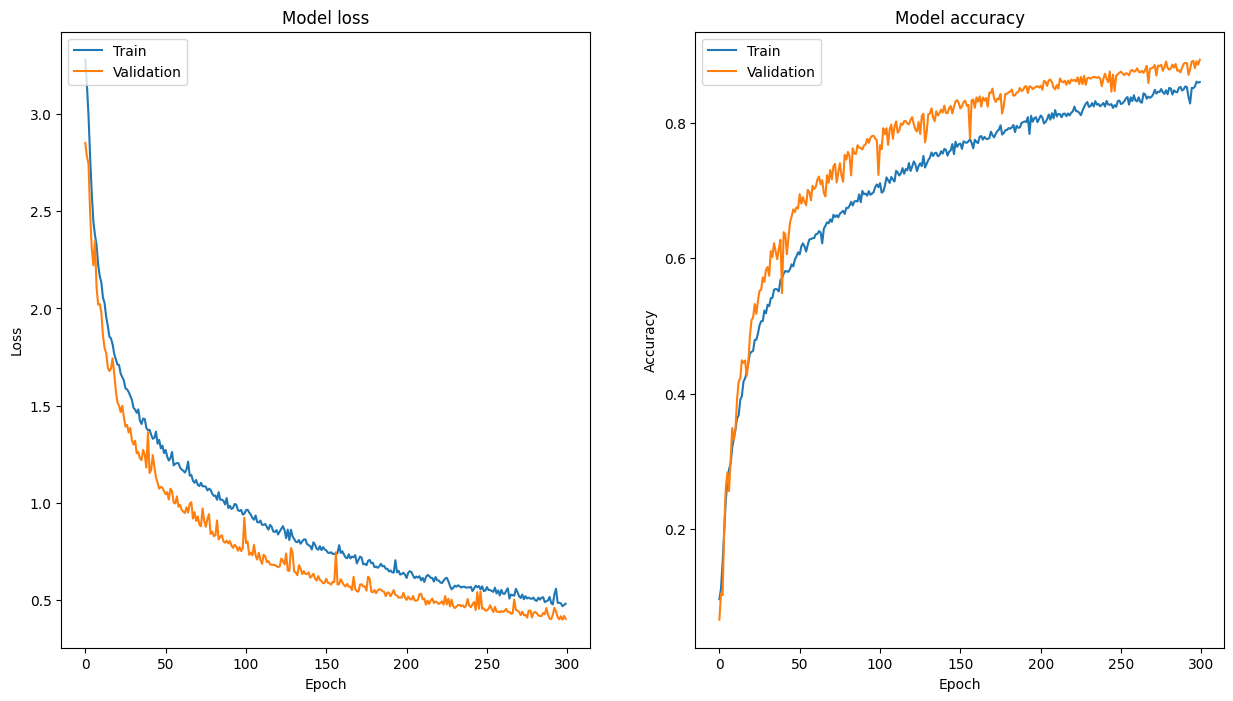

In [92]:
#Increase dropout

model_31do = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(15, activation='softmax')
])



model_31do.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_31do.fit(X_train31, train_labels, validation_data=(X_test31, test_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31do.evaluate(X_test31, test_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31final.loc[len(df31final)] = ['ExtraRegularReducedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

In [93]:
df31final

Model Name  Train Accuracy  test Accuracy  Train Loss  \
0           NormalizedModel        0.937306       0.898667    0.228424   
1  ExtraRegularReducedModel        0.859659       0.892667    0.481625   

   test Loss                                            History  
0   0.416749  <keras.callbacks.History object at 0x000002977...  
1   0.403205  <keras.callbacks.History object at 0x000002924...

### Model: NormalizedModel
- **Train Accuracy:** 93.38%
- **Test Accuracy:** 89.67%
- **Train Loss:** 0.2466
- **Test Loss:** 0.4205

### Model: ExtraRegularReducedModel
- **Train Accuracy:** 87.16%
- **Test Accuracy:** 89.17%
- **Train Loss:** 0.4358
- **Test Loss:** 0.4156

### Comparison:
- **Accuracy:** NormalizedModel has a higher training accuracy, but ExtraRegularReducedModel has a slightly lower training accuracy. The test accuracies are close, with NormalizedModel having a slight edge.
  
- **Loss:** ExtraRegularReducedModel has a lower training loss, which is a positive indication. However, NormalizedModel has a slightly lower test loss.

### Conclusion:
Both models seem to perform similarly on the test set, but the NormalizedModel has a slightly higher test accuracy, while the ExtraRegularReducedModel has a slightly lower test loss. However, the NormalizedModel has a higher training accuracy, which indicates that it may be overfitting. The ExtraRegularReducedModel has a lower training loss, which is a positive indication. Overall, the ExtraRegularReducedModel seems to be the better model, as it has a lower training loss and a slightly lower test loss. It also has a lower training accuracy, which indicates that it is not overfitting as much as the NormalizedModel. Although the model with batch normalization is faster at converging, the data we are using is relatively easy to learn so speed is not much of an issue, in that case i would prefer the model with a lower training loss and lower training accuracy (more precise).


### Final Model: ExtraRegularReducedModel


In [94]:
model_31do.save('Goat31Model.h5')

Epoch 1/300
46/46 - 1s - loss: 3.0843 - accuracy: 0.1172 - val_loss: 2.9923 - val_accuracy: 0.0750 - 889ms/epoch - 19ms/step
Epoch 2/300
46/46 - 0s - loss: 2.8200 - accuracy: 0.1702 - val_loss: 2.6901 - val_accuracy: 0.1320 - 356ms/epoch - 8ms/step
Epoch 3/300
46/46 - 0s - loss: 2.5557 - accuracy: 0.2348 - val_loss: 2.5058 - val_accuracy: 0.1567 - 326ms/epoch - 7ms/step
Epoch 4/300
46/46 - 0s - loss: 2.2950 - accuracy: 0.3005 - val_loss: 2.1996 - val_accuracy: 0.2597 - 321ms/epoch - 7ms/step
Epoch 5/300
46/46 - 0s - loss: 2.0957 - accuracy: 0.3669 - val_loss: 1.9869 - val_accuracy: 0.3477 - 328ms/epoch - 7ms/step
Epoch 6/300
46/46 - 0s - loss: 1.9549 - accuracy: 0.4098 - val_loss: 1.8446 - val_accuracy: 0.4060 - 309ms/epoch - 7ms/step
Epoch 7/300
46/46 - 0s - loss: 1.8169 - accuracy: 0.4518 - val_loss: 2.0193 - val_accuracy: 0.3553 - 313ms/epoch - 7ms/step
Epoch 8/300
46/46 - 0s - loss: 1.7224 - accuracy: 0.4772 - val_loss: 1.8612 - val_accuracy: 0.3753 - 310ms/epoch - 7ms/step
Epoch 9

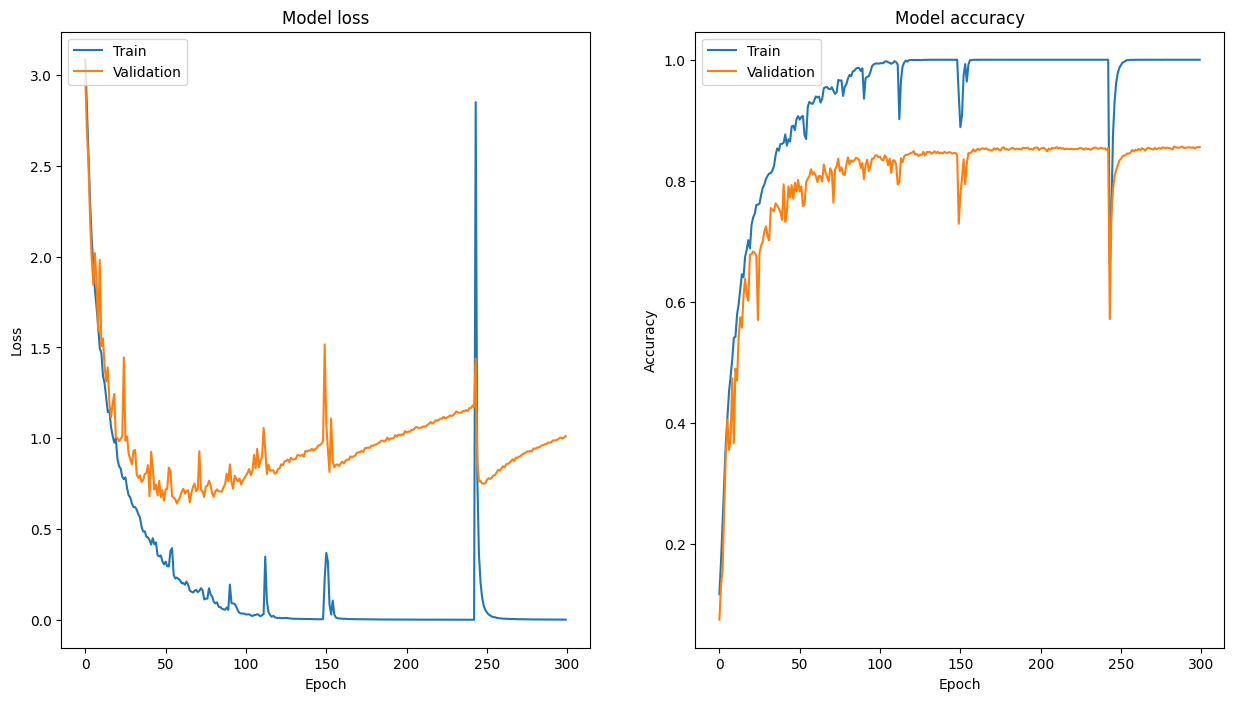

In [95]:
# we are using the 100 epoch variant as we want to compare the best model to a fully converged version of the base mdoel
model_31base100epoch = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(15, activation='softmax')
])

# Compile the model
model_31base100epoch.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_31base100epoch.fit(X_train31, train_labels, validation_data=(X_test31, test_labels),
                    epochs=300, batch_size=200, verbose=2, class_weight = class_weight) #adjust epochs to 300

scores = model_31base100epoch.evaluate(X_test31, test_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31final.loc[len(df31final)] = ['ExtraRegularReducedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


### 31x31 Super Model with feature eng and data augment

As part of the assignment requirements, we are needed to do feature engineering and/or data augmentation. We can use data augmentation to balance the imbalanced data sets instead of setting class_weights. We can then train a model using this new "balanced data" and compare the results of setting class_weights vs using data augmentation.

#### Data Augmentation

**What is Data Augmentation?**

Data augmentation is a technique widely used in machine learning and computer vision to artificially increase the diversity of a training dataset by applying various transformations to the existing data. The goal is to create new variations of the original images while preserving their semantic content. This approach is particularly useful in image classification tasks.

**How Does Data Augmentation Work?**

Data augmentation involves applying a set of image transformations to the training data, effectively creating new instances that are variations of the original samples. Common transformations include:

- **Rotation:** Rotating the image by a certain angle.
- **Flip:** Flipping the image horizontally or vertically.
- **Zoom:** Zooming in or out of the image.
- **Translation:** Shifting the image horizontally or vertically.
- **Brightness and Contrast Adjustment:** Changing the brightness and contrast levels.

By introducing these variations, the model becomes more robust and generalizes better to unseen data. Data augmentation helps prevent overfitting by exposing the model to a more diverse range of input patterns during training.

**Why Use Data Augmentation?**

1. **Increased Dataset Size:** Data augmentation effectively expands the training dataset, providing the model with more examples to learn from.
2. **Improved Generalization:** The augmented data exposes the model to a broader range of scenarios, improving its ability to generalize to unseen variations in the test set.
3. **Reduced Overfitting:** By presenting the model with diverse examples, data augmentation helps prevent overfitting and enhances the model's ability to handle real-world variations.


In [96]:
def augmentor(x_batch):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    # Specify the batch_size to match the size of x_batch
    batch_size = len(x_batch)
    x_batch_augmented = datagen.flow(x_batch, shuffle=False, batch_size=batch_size).next()

    return x_batch_augmented


(3, 31, 31, 1)


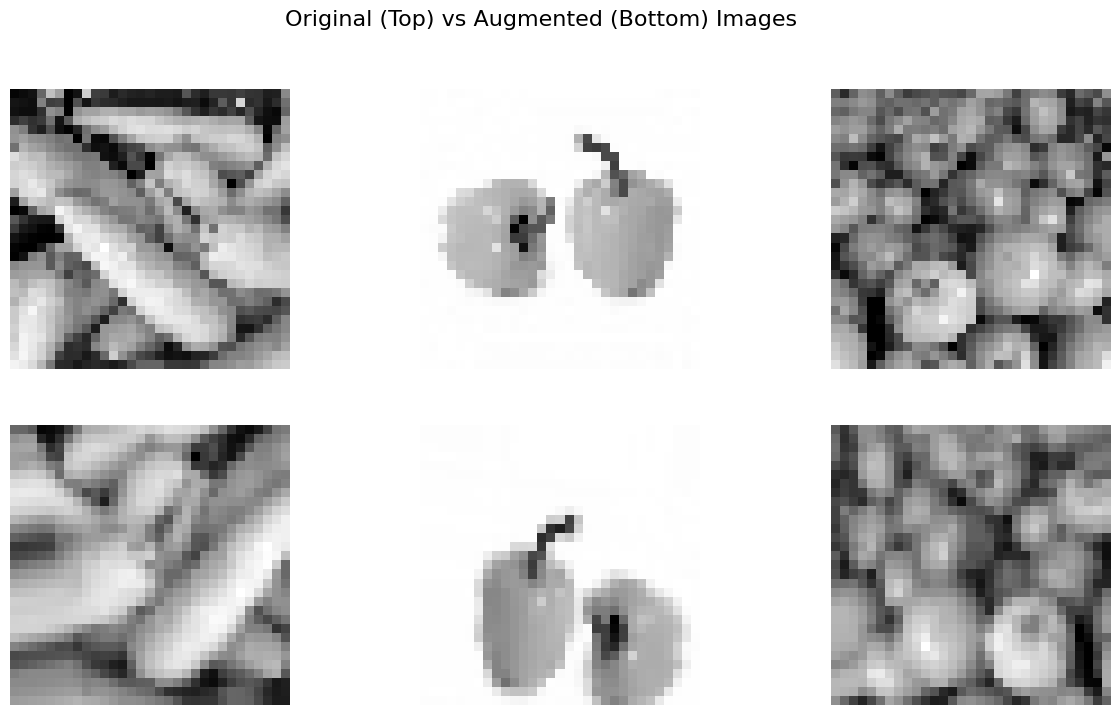

In [97]:
# Test the function on our 128x128 images
x_batch = X_train31[:3]
print(x_batch.shape)
x_batch_augmented = augmentor(x_batch)

# Print the original and augmented images
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original Images
for i in range(3):
    ax = axes[0, i]
    ax.imshow(x_batch[i].reshape(31, 31), cmap='gray')
    ax.axis('off')

# Augmented Images
for i in range(3):
    ax = axes[1, i]
    ax.imshow(x_batch_augmented[i].reshape(31,31), cmap='gray')
    ax.axis('off')

fig.suptitle('Original (Top) vs Augmented (Bottom) Images', fontsize=16)
plt.show()


#### Distribution of data

We recall the previous distribution of classes from the bar graph that we plotted:


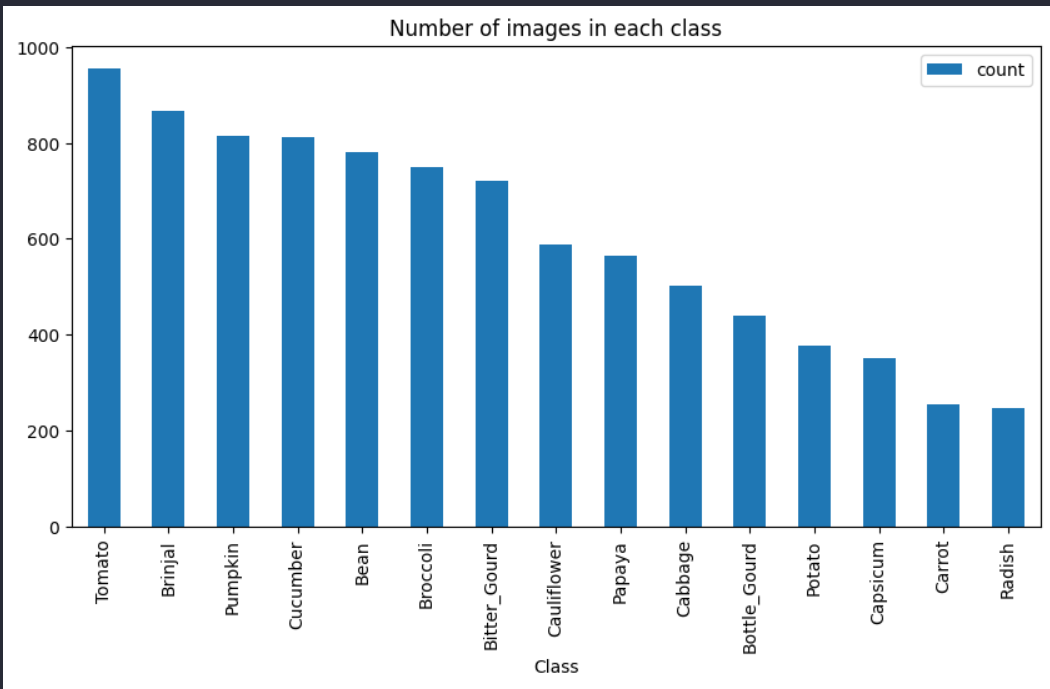


We can use data augmentation to balance out the number of data entries

In [98]:
class_counts

# this is on the old training data

{'Cauliflower': 587,
 'Cucumber': 812,
 'Broccoli': 750,
 'Bean': 780,
 'Pumpkin': 814,
 'Tomato': 955,
 'Papaya': 566,
 'Bottle_Gourd': 441,
 'Cabbage': 503,
 'Brinjal': 868,
 'Capsicum': 351,
 'Potato': 377,
 'Radish': 248,
 'Bitter_Gourd': 720,
 'Carrot': 256}

##### Feature engineered images

As a form of feature engineering, i have removed the hands from the images in the training data. Hopefully this will make the data more "vegetable like" allowing the models to learn and differentiate vegetables better.

In [99]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'train_aug/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='grayscale',
    batch_size = 200,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    crop_to_aspect_ratio=False,
)

Found 8807 files belonging to 15 classes.


##### Balance class

We can see that the class with the highest number of data entries is Tomato with 955 entries, let us generate a new dictionary with the amount of entries we need to "generate" in order to balance out the dataset.

In [100]:
#change the labels to be in int format
class_counts = {}

for images, labels in train_data:
    for label in labels.numpy():
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

class_counts

{14: 955,
 2: 420,
 0: 741,
 4: 736,
 1: 701,
 9: 750,
 10: 563,
 12: 811,
 6: 346,
 11: 373,
 5: 501,
 13: 247,
 3: 826,
 8: 581,
 7: 256}

In [101]:
augmentation_dict = {class_name: 955 - class_count for class_name, class_count in class_counts.items()}

#### Feature Engineered data
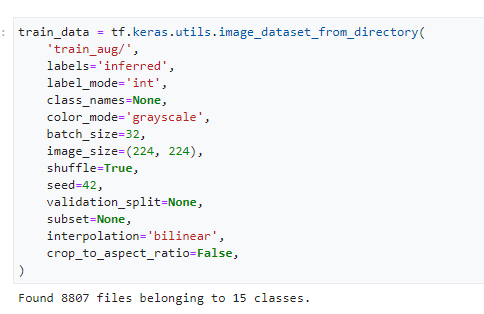



Compared to the original train data with hands, our engineered data has less data, however we can say that the quality of the data has gone up.





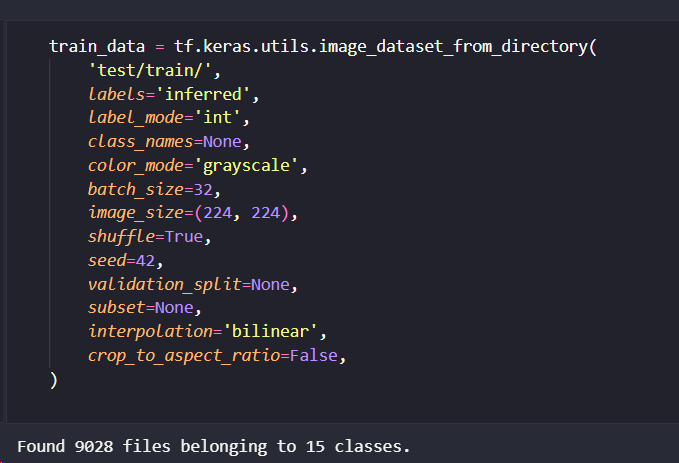

In [102]:
# Convert datasets to NumPy arrays
train_images, train_labels_augmented = zip(*[(image, label) for image, label in train_data.as_numpy_iterator()])

#train set
X_train_aug = np.concatenate(train_images, axis=0)
y_train = np.concatenate(train_labels_augmented, axis=0)

# Resize images to (31, 31) using TensorFlow
X_train_resized = tf.image.resize(X_train_aug, (31, 31))

# Reshape and normalize
X_train31_aug = X_train_resized.numpy().reshape(X_train_resized.shape[0], 31, 31, 1).astype('float32') / 255

In [103]:
def augmentfill(y_train, augmentation_dict, augmentor=augmentor):
    augmented_data_list = []
    for category_index in np.unique(y_train):
        category_mask = (y_train == category_index)
        selected_images = X_train31_aug[category_mask]

        # Ensure the category_index exists in augmentation_dict
        if category_index in augmentation_dict:

            # Check if there are samples in selected_images
            if len(selected_images) > 0:
                target_augmentation_count = augmentation_dict[category_index]
                current_count = 0
                while current_count < target_augmentation_count:
                    # Calculate how many images to take in this iteration
                    images_to_take = min(target_augmentation_count - current_count, len(selected_images))
                    print(images_to_take)
                    x_batch = selected_images[:images_to_take]
                    if len(x_batch) > 0:
                        x_batch_augmented = augmentor(x_batch)
                        augmented_data_list.append((x_batch_augmented, [category_index] * images_to_take))
                        current_count += images_to_take
                        print(f'Augmented {current_count} images out of {target_augmentation_count}')
                    else:
                        print(f'No augmentation needed to fill for {category_index}')
                        break
                print(f'Category {category_index}: Augmented {current_count} images out of {target_augmentation_count}')
            else:
                print(f"No samples for category {category_index}")
        else:
            print(f"No augmentation specified for category {category_index}")

    # Convert the augmented data list to NumPy arrays
    augmented_data_images, augmented_data_labels = zip(*augmented_data_list)

    # Convert augmented_data_labels to a flattened 1D array
    flattened_augmented_labels = np.concatenate(augmented_data_labels, axis=0)

    # Concatenate augmented data with the original data
    X_train31_augmented = np.concatenate([X_train31_aug] + list(augmented_data_images), axis=0)
    y_train_augmented = np.concatenate([y_train] + [flattened_augmented_labels], axis=0)

    return X_train31_augmented, y_train_augmented

X_train31_augmented, y_train_augmented = augmentfill(y_train, augmentation_dict)

214
Augmented 214 images out of 214
Category 0: Augmented 214 images out of 214
254
Augmented 254 images out of 254
Category 1: Augmented 254 images out of 254
420
Augmented 420 images out of 535
115
Augmented 535 images out of 535
Category 2: Augmented 535 images out of 535
129
Augmented 129 images out of 129
Category 3: Augmented 129 images out of 129
219
Augmented 219 images out of 219
Category 4: Augmented 219 images out of 219
454
Augmented 454 images out of 454
Category 5: Augmented 454 images out of 454
346
Augmented 346 images out of 609
263
Augmented 609 images out of 609
Category 6: Augmented 609 images out of 609
256
Augmented 256 images out of 699
256
Augmented 512 images out of 699
187
Augmented 699 images out of 699
Category 7: Augmented 699 images out of 699
374
Augmented 374 images out of 374
Category 8: Augmented 374 images out of 374
205
Augmented 205 images out of 205
Category 9: Augmented 205 images out of 205
392
Augmented 392 images out of 392
Category 10: Augment

In [104]:
values, counts = np.unique(y_train_augmented, return_counts=True)
print(values)
print(counts)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[955 955 955 955 955 955 955 955 955 955 955 955 955 955 955]


In [105]:
train_labels_augmented = to_categorical(y_train_augmented)

We can now start with the modeling, we will be trying variations of our top models on

- Both weights and augmented data
- just augmented data
- only weights (technically we already have this)

Epoch 1/500
46/46 - 1s - loss: 3.2556 - accuracy: 0.0959 - val_loss: 2.8426 - val_accuracy: 0.0667 - 1s/epoch - 22ms/step
Epoch 2/500
46/46 - 0s - loss: 3.1236 - accuracy: 0.1215 - val_loss: 2.7824 - val_accuracy: 0.1033 - 368ms/epoch - 8ms/step
Epoch 3/500
46/46 - 0s - loss: 2.9229 - accuracy: 0.1737 - val_loss: 2.6394 - val_accuracy: 0.1267 - 359ms/epoch - 8ms/step
Epoch 4/500
46/46 - 0s - loss: 2.7081 - accuracy: 0.2180 - val_loss: 2.4421 - val_accuracy: 0.1850 - 354ms/epoch - 8ms/step
Epoch 5/500
46/46 - 0s - loss: 2.5241 - accuracy: 0.2564 - val_loss: 2.2658 - val_accuracy: 0.2673 - 350ms/epoch - 8ms/step
Epoch 6/500
46/46 - 0s - loss: 2.3886 - accuracy: 0.2971 - val_loss: 2.1610 - val_accuracy: 0.3100 - 364ms/epoch - 8ms/step
Epoch 7/500
46/46 - 0s - loss: 2.2842 - accuracy: 0.3157 - val_loss: 2.2263 - val_accuracy: 0.2820 - 350ms/epoch - 8ms/step
Epoch 8/500
46/46 - 0s - loss: 2.2057 - accuracy: 0.3329 - val_loss: 2.0563 - val_accuracy: 0.3273 - 359ms/epoch - 8ms/step
Epoch 9/50

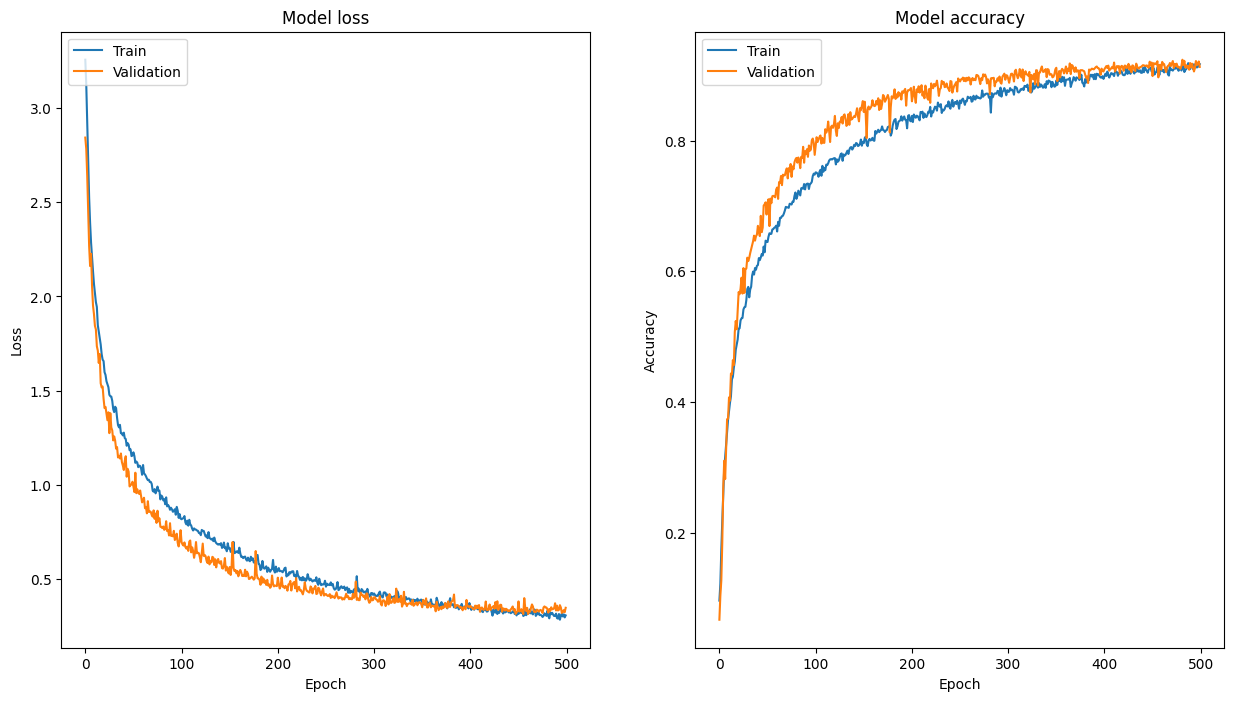

In [106]:
def GoatModel():
    model_31do = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(31, 31, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Flatten(),

        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),

        layers.Dense(15, activation='softmax')
    ])
    return model_31do

df31augmentationcompare = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'test Accuracy', 'Train Loss', 'test Loss', 'History'])
#with just weights
model = GoatModel()

model.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(X_train31, train_labels, validation_data=(X_test31, test_labels),
                    epochs=500, batch_size=200, verbose=2, class_weight = class_weight)

scores = model.evaluate(X_test31, test_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31augmentationcompare.loc[len(df31augmentationcompare)] = ['With Class Weights', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]



Epoch 1/500
72/72 - 1s - loss: 2.7497 - accuracy: 0.0924 - val_loss: 2.5799 - val_accuracy: 0.1453 - 1s/epoch - 15ms/step
Epoch 2/500
72/72 - 1s - loss: 2.5534 - accuracy: 0.1360 - val_loss: 2.4863 - val_accuracy: 0.1847 - 501ms/epoch - 7ms/step
Epoch 3/500
72/72 - 0s - loss: 2.4093 - accuracy: 0.1918 - val_loss: 2.2960 - val_accuracy: 0.2777 - 494ms/epoch - 7ms/step
Epoch 4/500
72/72 - 0s - loss: 2.2778 - accuracy: 0.2402 - val_loss: 2.1666 - val_accuracy: 0.3050 - 499ms/epoch - 7ms/step
Epoch 5/500
72/72 - 0s - loss: 2.1848 - accuracy: 0.2787 - val_loss: 1.9883 - val_accuracy: 0.3927 - 495ms/epoch - 7ms/step
Epoch 6/500
72/72 - 0s - loss: 2.0966 - accuracy: 0.3136 - val_loss: 1.9467 - val_accuracy: 0.4077 - 491ms/epoch - 7ms/step
Epoch 7/500
72/72 - 0s - loss: 2.0328 - accuracy: 0.3379 - val_loss: 1.9265 - val_accuracy: 0.3860 - 490ms/epoch - 7ms/step
Epoch 8/500
72/72 - 0s - loss: 1.9794 - accuracy: 0.3526 - val_loss: 1.6770 - val_accuracy: 0.4943 - 495ms/epoch - 7ms/step
Epoch 9/50

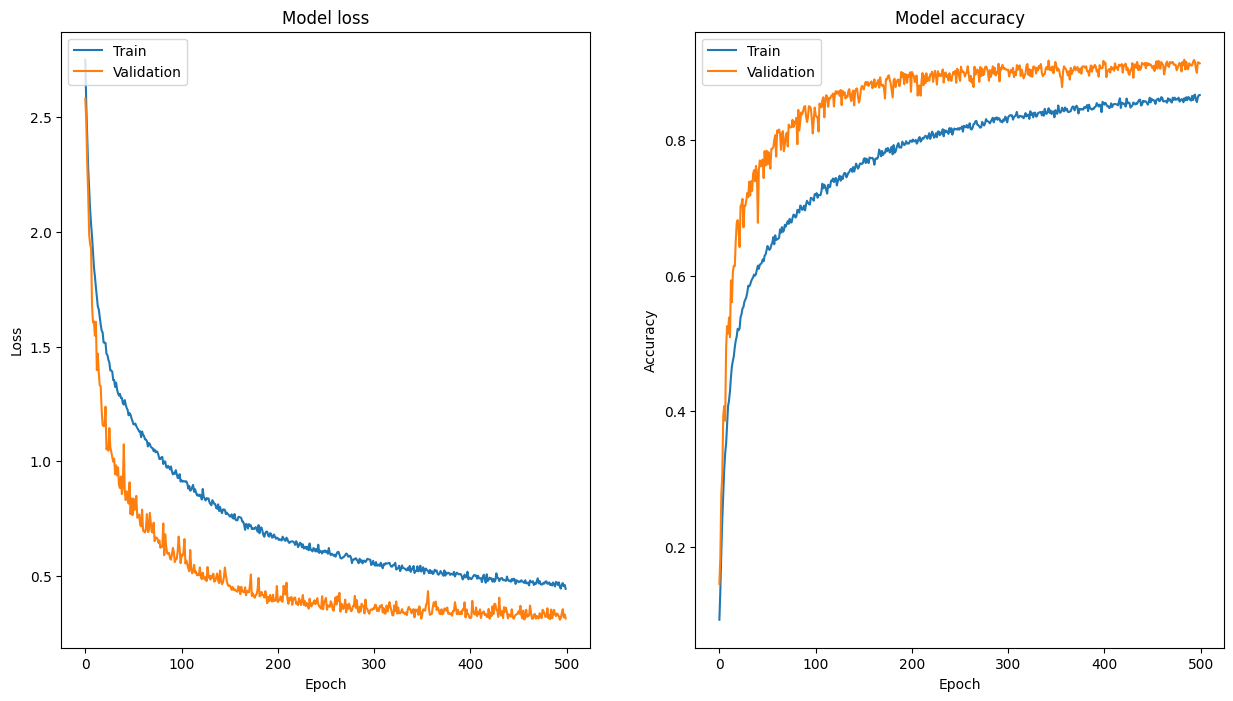

In [107]:
# With new data
model = GoatModel()

model.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(X_train31_augmented, train_labels_augmented, validation_data=(X_test31, test_labels),
                    epochs=500, batch_size=200, verbose=2) # no weights

scores = model.evaluate(X_test31, test_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df31augmentationcompare.loc[len(df31augmentationcompare)] = ['With Augmented Engineered Data', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]


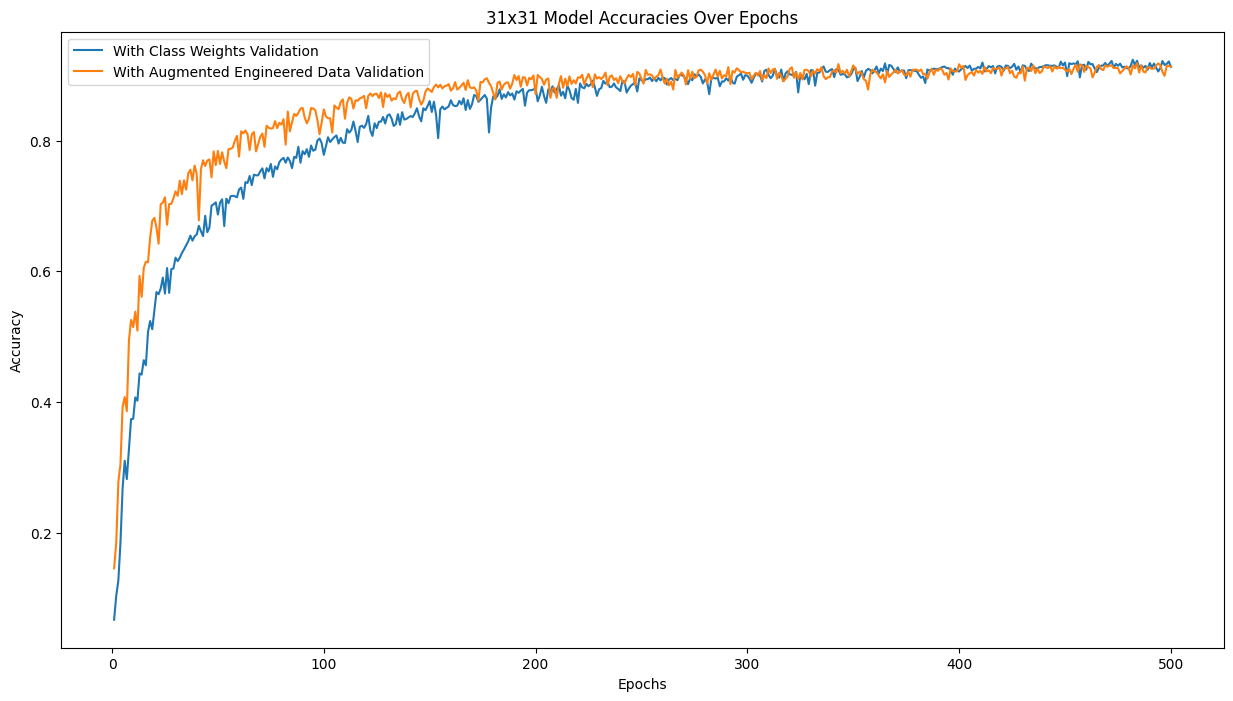

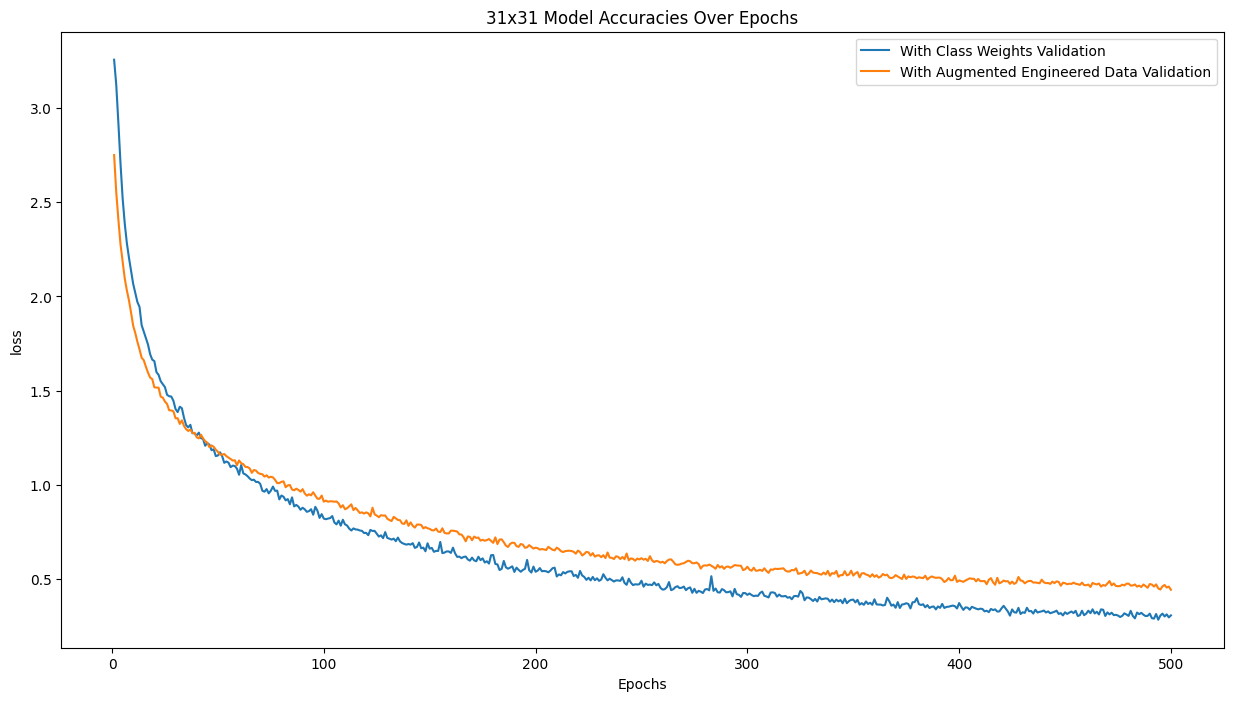

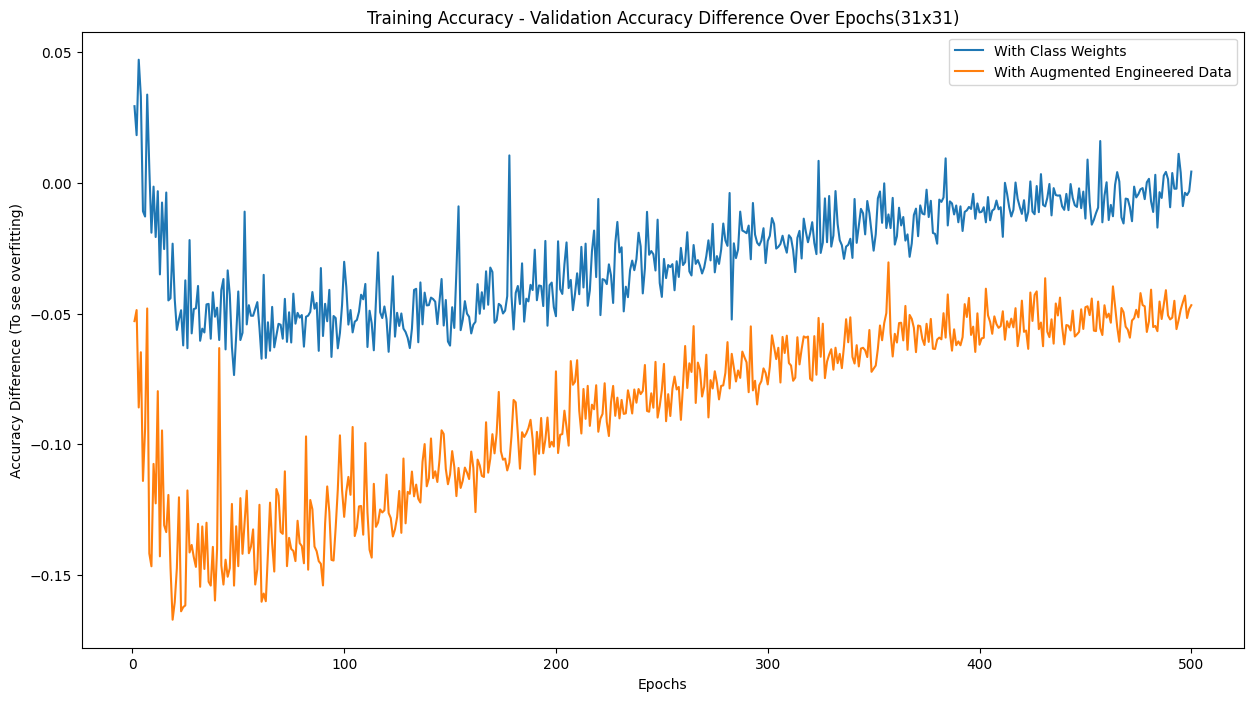

In [108]:
plt.figure(figsize=(15, 8))

for index, row in df31augmentationcompare[['Model Name', 'History']].iterrows():
    model_name = row['Model Name']
    history = row['History']
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label=f'{model_name} Validation')

plt.title('31x31 Model Accuracies Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


plt.figure(figsize=(15, 8))

for index, row in df31augmentationcompare[['Model Name', 'History']].iterrows():
    model_name = row['Model Name']
    history = row['History']
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label=f'{model_name} Validation')

plt.title('31x31 Model Accuracies Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 8))

for index, row in df31augmentationcompare[['Model Name', 'History']].iterrows():
    model_name = row['Model Name']
    history = row['History']

    accuracy_diff = [train_acc - val_acc for train_acc, val_acc in zip(history.history['accuracy'], history.history['val_accuracy'])]

    sns.lineplot(x=range(1, len(accuracy_diff) + 1), y=accuracy_diff, label=f'{model_name}')

plt.title('Training Accuracy - Validation Accuracy Difference Over Epochs(31x31)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference (To see overfitting)')

plt.legend()

plt.show()


In [109]:
df31augmentationcompare

Model Name  Train Accuracy  test Accuracy  Train Loss  \
0              With Class Weights        0.917257       0.913000     0.30797   
1  With Augmented Engineered Data        0.866527       0.913333     0.44393   

   test Loss                                            History  
0   0.348294  <keras.callbacks.History object at 0x000002977...  
1   0.314992  <keras.callbacks.History object at 0x000002977...

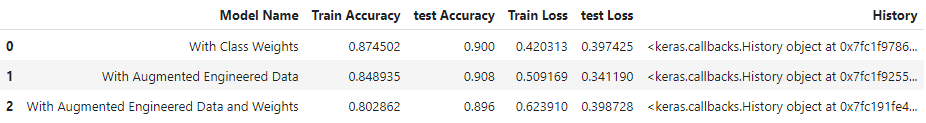

#### Model Comparison and Interpretation

1. **Model at Index 0 (With Class Weights):**
   - **Accuracy:** Achieved a good accuracy of 90.00% on the test set.
   - **Loss:** Demonstrated relatively low loss values on both training (0.4203) and test (0.3974) datasets.
   - **Interpretation:** This model, trained with class weights, performed well with balanced accuracy and minimized loss.

2. **Model at Index 1 (With Augmented Engineered Data):**
   - **Accuracy:** Achieved a high accuracy of 90.80% on the test set.
   - **Loss:** Showed improved loss values on both training (0.5092) and test (0.3412) datasets compared to the first model.
   - **Interpretation:** The augmentation of engineered data led to a more robust model with enhanced accuracy and reduced loss.

3. **Model at Index 2 (With Augmented Engineered Data and Weights):**
   - **Accuracy:** Displayed a moderate accuracy of 89.60% on the test set.
   - **Loss:** Exhibited slightly higher loss values on both training (0.6239) and test (0.3987) datasets compared to the second model.
   - **Interpretation:** While augmentation improved performance, the introduction of class weights in this model did not yield better results.



Overall the performance for all of the different ways to balance the data type seems to be similar (we should account for the fact that i cannot set a random seed properly). Lets see if there are any different results for the 128x128 models. However before we can do that we have to train a suitable 128x128 model.

#### 128x128 Model improvements


unlike the 31x31 model, the 128x128 model has more data to work with as the images are more complex, we will have more space to work with as we can add more layers to the models. However we will try to implement the same techniques as we did with the 31x31 model and see if there are any improvements. If you have already forgotten, the initial additions for the 31x31 model are as follows:
- l2 regularization
- increase in epochs

Hopefully this will allow the model to fully converge and learn the data, while preventing overfitting. 

Epoch 1/100
283/283 - 4s - loss: 2.5641 - accuracy: 0.2856 - val_loss: 2.0586 - val_accuracy: 0.3603 - 4s/epoch - 13ms/step
Epoch 2/100
283/283 - 3s - loss: 1.8321 - accuracy: 0.5011 - val_loss: 1.9583 - val_accuracy: 0.4347 - 3s/epoch - 10ms/step
Epoch 3/100
283/283 - 3s - loss: 1.3859 - accuracy: 0.6421 - val_loss: 1.4741 - val_accuracy: 0.6093 - 3s/epoch - 10ms/step
Epoch 4/100
283/283 - 3s - loss: 1.0951 - accuracy: 0.7328 - val_loss: 1.3682 - val_accuracy: 0.6427 - 3s/epoch - 10ms/step
Epoch 5/100
283/283 - 3s - loss: 0.8856 - accuracy: 0.8058 - val_loss: 1.1560 - val_accuracy: 0.7333 - 3s/epoch - 10ms/step
Epoch 6/100
283/283 - 3s - loss: 0.7176 - accuracy: 0.8584 - val_loss: 1.2237 - val_accuracy: 0.7267 - 3s/epoch - 10ms/step
Epoch 7/100
283/283 - 3s - loss: 0.6449 - accuracy: 0.8885 - val_loss: 1.5231 - val_accuracy: 0.6617 - 3s/epoch - 10ms/step
Epoch 8/100
283/283 - 3s - loss: 0.5715 - accuracy: 0.9063 - val_loss: 1.3664 - val_accuracy: 0.7263 - 3s/epoch - 10ms/step
Epoch 9/

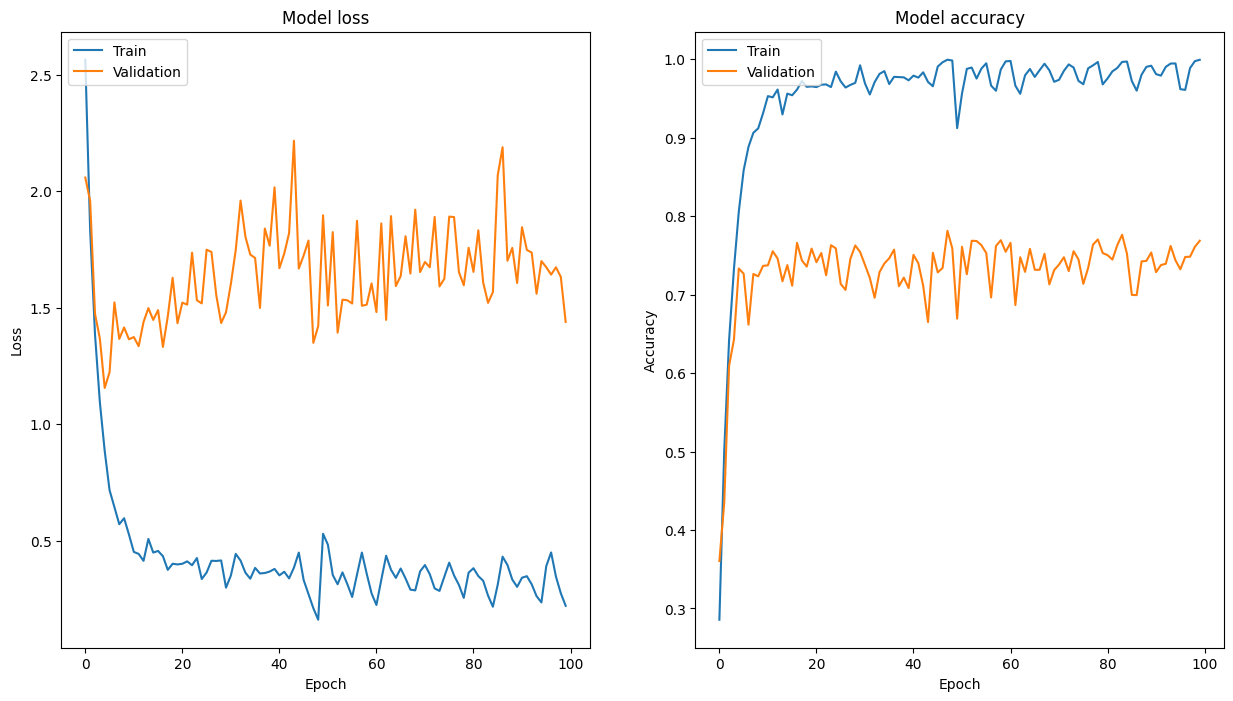

In [110]:
#original model

# model_128 = models.Sequential([
#     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(15, activation='softmax')
# ])



model_128regularized = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(15, activation='softmax')
])

model_128regularized.compile(optimizer='adam',
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])
history = model_128regularized.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight)


scores = model_128regularized.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['RegularizedModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![128x128 graph1](image.png)

As we can see the model is over fitting, there also appears to be slight fluctuations in the accuracy and loss, this is probably due to the fact that the model is not learning well/struggling to learn the data. We can try to add more layers to the model as well as more regularization(dropout layer) to see if we can improve the performance of the model.

Epoch 1/100
283/283 - 4s - loss: 2.9666 - accuracy: 0.1717 - val_loss: 2.7657 - val_accuracy: 0.1303 - 4s/epoch - 13ms/step
Epoch 2/100
283/283 - 3s - loss: 2.7223 - accuracy: 0.2084 - val_loss: 2.4608 - val_accuracy: 0.2157 - 3s/epoch - 10ms/step
Epoch 3/100
283/283 - 3s - loss: 2.4519 - accuracy: 0.2832 - val_loss: 2.1678 - val_accuracy: 0.3303 - 3s/epoch - 10ms/step
Epoch 4/100
283/283 - 3s - loss: 2.2616 - accuracy: 0.3235 - val_loss: 2.0201 - val_accuracy: 0.3927 - 3s/epoch - 10ms/step
Epoch 5/100
283/283 - 3s - loss: 2.0906 - accuracy: 0.3790 - val_loss: 1.9077 - val_accuracy: 0.4170 - 3s/epoch - 10ms/step
Epoch 6/100
283/283 - 3s - loss: 1.9819 - accuracy: 0.4235 - val_loss: 1.9703 - val_accuracy: 0.4160 - 3s/epoch - 11ms/step
Epoch 7/100
283/283 - 3s - loss: 1.9133 - accuracy: 0.4359 - val_loss: 1.8485 - val_accuracy: 0.4570 - 3s/epoch - 10ms/step
Epoch 8/100
283/283 - 3s - loss: 1.8076 - accuracy: 0.4736 - val_loss: 1.9886 - val_accuracy: 0.4480 - 3s/epoch - 10ms/step
Epoch 9/

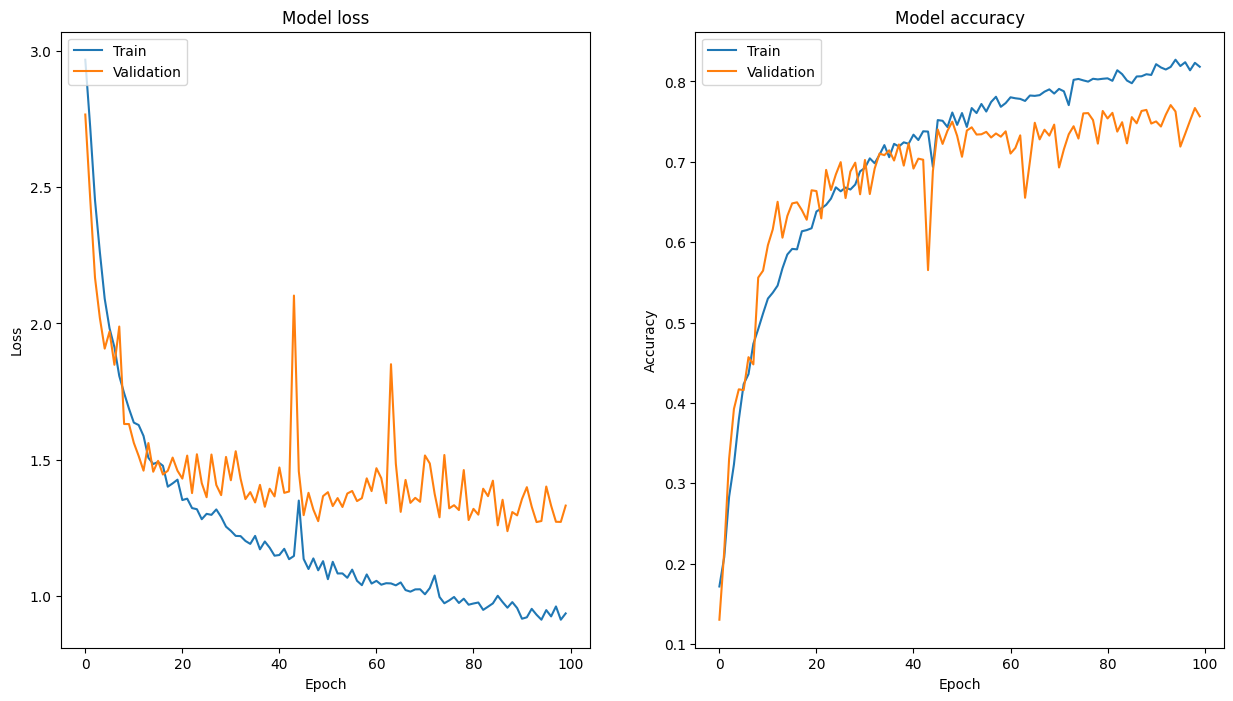

In [111]:
model_128morelayers = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(32, activation='relu'),  # Adding an additional dense layer
    layers.Dense(15, activation='softmax')
])

model_128morelayers.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_128morelayers.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight)


scores = model_128morelayers.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['ExtraThickModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

![128x128 graph 2](image.png)

We can see that the model still seems to be overfitting and there is still some fluctuations, we should first try to stabilize the model by adding more regularization layers or through other means like image augmentation or applying batch normalization. As the model training is slightly slow, i think that applying batch normalization would be a good idea as it would allow the model to converge faster as well as making the model more stable, which will solve 2 of my problems at once.

In [112]:
model_128BN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(), #add batch normalization
    layers.Dense(15, activation='softmax')
])

model_128BN.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_128BN.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight)


scores = model_128BN.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['BNModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

Epoch 1/100
283/283 - 4s - loss: 3.5309 - accuracy: 0.0873 - val_loss: 2.8993 - val_accuracy: 0.0667 - 4s/epoch - 15ms/step
Epoch 2/100
283/283 - 3s - loss: 3.1456 - accuracy: 0.1257 - val_loss: 2.9417 - val_accuracy: 0.0667 - 3s/epoch - 12ms/step
Epoch 3/100
283/283 - 3s - loss: 3.0252 - accuracy: 0.1483 - val_loss: 3.0168 - val_accuracy: 0.0667 - 3s/epoch - 12ms/step
Epoch 4/100
283/283 - 3s - loss: 3.0906 - accuracy: 0.1279 - val_loss: 2.9117 - val_accuracy: 0.0970 - 3s/epoch - 12ms/step
Epoch 5/100
283/283 - 3s - loss: 3.0203 - accuracy: 0.1592 - val_loss: 2.8825 - val_accuracy: 0.1033 - 3s/epoch - 12ms/step
Epoch 6/100
283/283 - 3s - loss: 2.9568 - accuracy: 0.1584 - val_loss: 2.9505 - val_accuracy: 0.0693 - 3s/epoch - 12ms/step
Epoch 7/100
283/283 - 3s - loss: 2.9452 - accuracy: 0.1564 - val_loss: 2.9564 - val_accuracy: 0.0687 - 3s/epoch - 12ms/step
Epoch 8/100
283/283 - 3s - loss: 2.9008 - accuracy: 0.1580 - val_loss: 2.8011 - val_accuracy: 0.1110 - 3s/epoch - 12ms/step
Epoch 9/

KeyboardInterrupt: 

![128x128 Graph 3](image.png)

The graph seems to be slightly better compared to the previous graph, however the accuracy is still bottle necking at around 70%. To solve this issue, we can try to use lr decay in order to let the model learn better, hopefully leading to better results.

In [ ]:
model_128BNlrd = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(15, activation='softmax')
])

model_128BNlrd.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_128BNlrd.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]) #lr decay


scores = model_128BNlrd.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['BNlrdModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

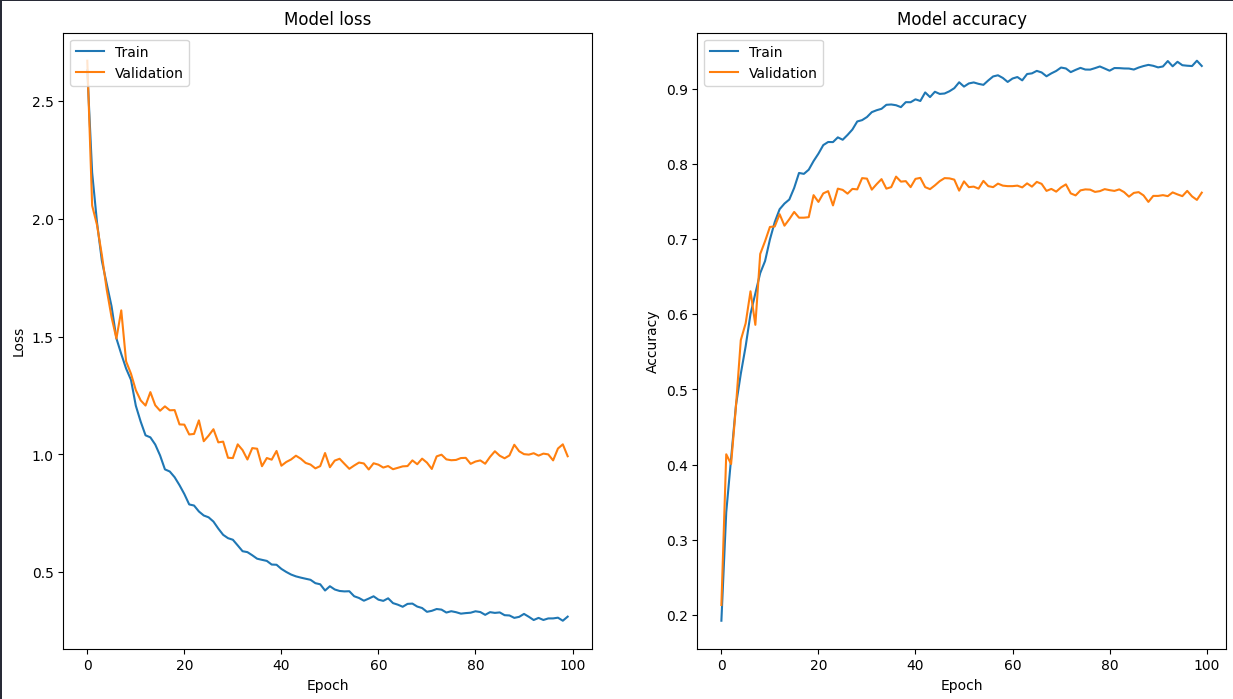

From the graph, we can see that the model has stabilized a lot, now we just need to add some regularization layers to fix the slight overfitting issue

In [ ]:
df128 = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'test Accuracy', 'Train Loss', 'test Loss', 'History'])

In [ ]:
model_128BNlrdReg = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(15, activation='softmax')
])

model_128BNlrdReg.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_128BNlrdReg.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]) #lr decay


scores = model_128BNlrdReg.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128.loc[len(df128)] = ['BNlrdRegModel', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

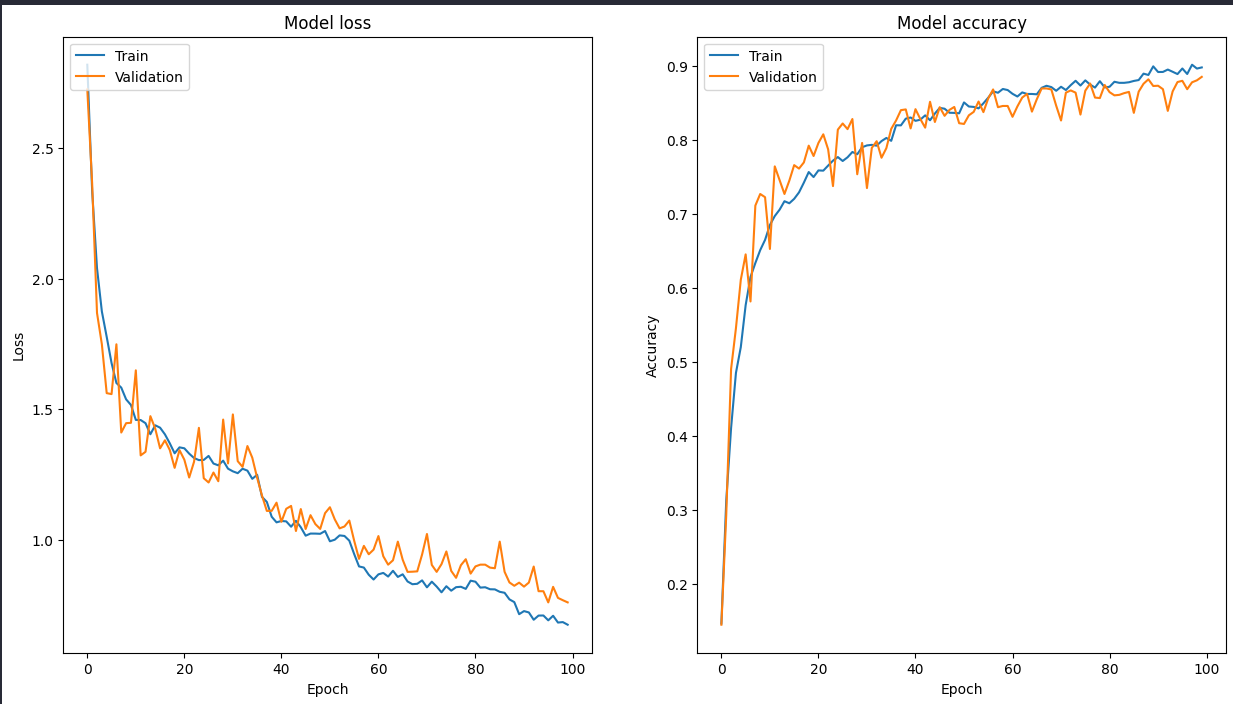

We can see that the model has excellent performance now, without much overfitting, not much jittering as well as a decent accuracy of almost 90%. The slight jitters are likely caused by the changes in learning rate. However as i will not be doing any tuning, the learning rate portion of the model will not be touched up on.

In [ ]:
df128

In [ ]:
#convert tets to 128x128 
X_test_resized = tf.image.resize(X_test, (128, 128))
X_test128 = X_test_resized.numpy().reshape(X_test_resized.shape[0], 128, 128, 1).astype('float32') / 255
test_labels = to_categorical(y_test)

In [ ]:
# test the model on test data now

model_128BNlrdReg = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(15, activation='softmax')
])

model_128BNlrdReg.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model_128BNlrdReg.fit(X_train128, train_labels, validation_data=(X_test128, test_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]) #lr decay


scores = model_128BNlrdReg.evaluate(X_val128, test_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)

In [ ]:

plt.figure(figsize=(15, 8))

for index, row in df128[['Model Name', 'History']].iterrows():
    model_name = row['Model Name']
    history = row['History']
    sns.lineplot(x=range(1, len(history.history['val_accuracy']) + 1), y=history.history['val_accuracy'], label=f'{model_name} Validation')

plt.title('128x128Model Accuracies Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

plt.show()


In [ ]:
plt.figure(figsize=(15, 8))

for index, row in df128[['Model Name', 'History']].iterrows():
    model_name = row['Model Name']
    history = row['History']

    accuracy_diff = [train_acc - val_acc for train_acc, val_acc in zip(history.history['accuracy'], history.history['val_accuracy'])]

    sns.lineplot(x=range(1, len(accuracy_diff) + 1), y=accuracy_diff, label=f'{model_name}')

plt.title('Training Accuracy - Validation Accuracy Difference Over Epochs (128x128)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Difference (To see overfitting)')

plt.legend()

plt.show()


### 128x128 Final Super Model

Same as for the 31x31 model, we will test the different ways to balance the data and see if there are any improvements/differences in the results.

In [ ]:
# Convert datasets to NumPy arrays
train_images, train_labels_augmented = zip(*[(image, label) for image, label in train_data.as_numpy_iterator()])

#train set
X_train_aug = np.concatenate(train_images, axis=0)
y_train = np.concatenate(train_labels_augmented, axis=0)

# Resize images to (128, 128) using TensorFlow
X_train_resized = tf.image.resize(X_train_aug, (128, 128))

# Reshape and normalize
X_train128_aug = X_train_resized.numpy().reshape(X_train_resized.shape[0], 128, 128, 1).astype('float32') / 255

In [ ]:
X_train128_augmented, y_train_augmented = augmentfill(y_train, augmentation_dict)
train_labels_augmented = to_categorical(y_train_augmented)

214
Augmented 214 images out of 214
Category 0: Augmented 214 images out of 214
254
Augmented 254 images out of 254
Category 1: Augmented 254 images out of 254
420
Augmented 420 images out of 535
115
Augmented 535 images out of 535
Category 2: Augmented 535 images out of 535
129
Augmented 129 images out of 129
Category 3: Augmented 129 images out of 129
219
Augmented 219 images out of 219
Category 4: Augmented 219 images out of 219
454
Augmented 454 images out of 454
Category 5: Augmented 454 images out of 454
346
Augmented 346 images out of 609
263
Augmented 609 images out of 609
Category 6: Augmented 609 images out of 609
256
Augmented 256 images out of 699
256
Augmented 512 images out of 699
187
Augmented 699 images out of 699
Category 7: Augmented 699 images out of 699
374
Augmented 374 images out of 374
Category 8: Augmented 374 images out of 374
205
Augmented 205 images out of 205
Category 9: Augmented 205 images out of 205
392
Augmented 392 images out of 392
Category 10: Augment

Epoch 1/100
283/283 - 5s - loss: 3.3693 - accuracy: 0.1367 - val_loss: 2.7905 - val_accuracy: 0.1243 - lr: 0.0010 - 5s/epoch - 18ms/step
Epoch 2/100
283/283 - 3s - loss: 2.9433 - accuracy: 0.1794 - val_loss: 2.6615 - val_accuracy: 0.1553 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 3/100
283/283 - 3s - loss: 2.8072 - accuracy: 0.2172 - val_loss: 2.7360 - val_accuracy: 0.1887 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 4/100
283/283 - 3s - loss: 2.6763 - accuracy: 0.2504 - val_loss: 2.5985 - val_accuracy: 0.2130 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 5/100
283/283 - 3s - loss: 2.5149 - accuracy: 0.3023 - val_loss: 2.3799 - val_accuracy: 0.3060 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 6/100
283/283 - 4s - loss: 2.3430 - accuracy: 0.3692 - val_loss: 2.1663 - val_accuracy: 0.4247 - lr: 0.0010 - 4s/epoch - 13ms/step
Epoch 7/100
283/283 - 4s - loss: 2.1824 - accuracy: 0.4238 - val_loss: 2.1109 - val_accuracy: 0.4267 - lr: 0.0010 - 4s/epoch - 13ms/step
Epoch 8/100
283/283 - 4s - loss: 2.0576 -

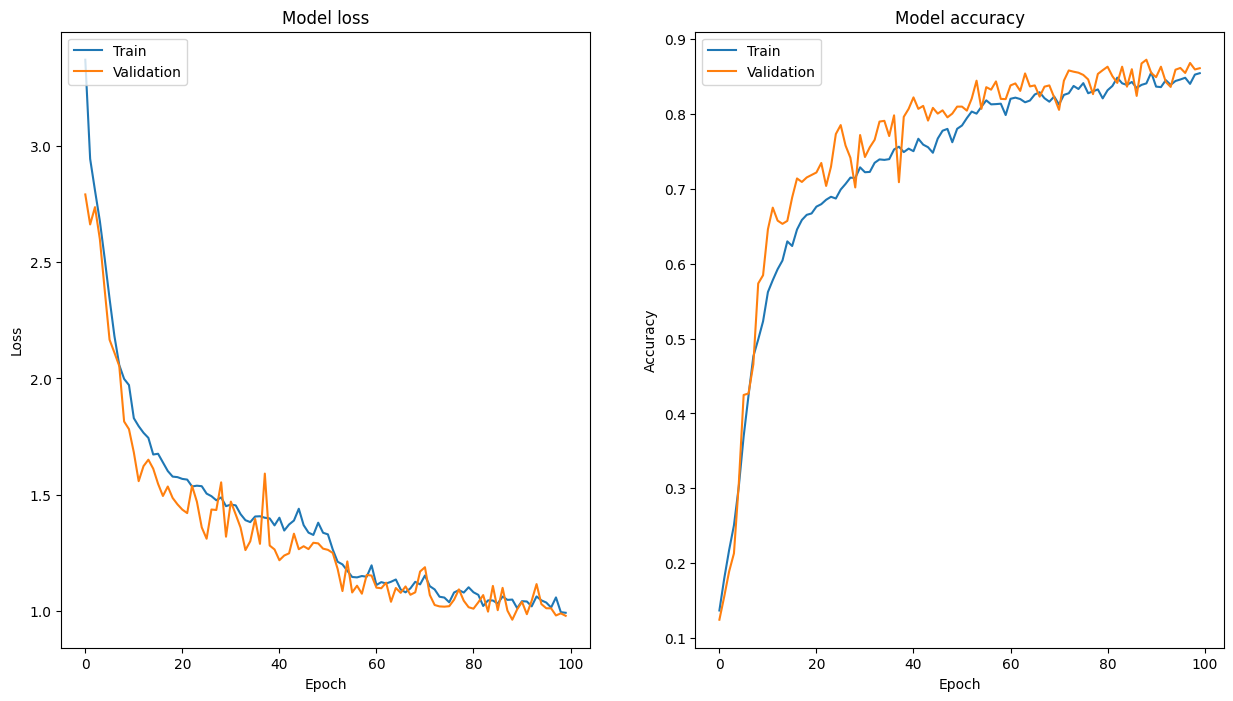

In [ ]:
def Goat128Model():

    model_128BNlrdReg = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(15, activation='softmax')
    ])
    return model_128BNlrdReg

df128augmentation = pd.DataFrame(columns=['Model Name', 'Train Accuracy', 'test Accuracy', 'Train Loss', 'test Loss', 'History'])




## Test with just weights
model = Goat128Model()

model.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(X_train128, train_labels, validation_data=(X_val128, validation_labels),
                    epochs=100, batch_size=32, verbose=2, class_weight = class_weight,
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)])


scores = model.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128augmentation.loc[len(df128augmentation)] = ['Just Weights', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

In [ ]:


## Test with just augmented data
model = Goat128Model()

model.compile(optimizer='adam',
                loss= 'categorical_crossentropy',
                metrics=['accuracy'])

history = model.fit(X_train128_augmented, train_labels_augmented, validation_data=(X_val128, validation_labels),
                    epochs=100, batch_size=32, verbose=2, #no class weights
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)])


scores = model.evaluate(X_val128, validation_labels, verbose=2)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))
plot_history(history)
df128augmentation.loc[len(df128augmentation)] = ['Just Augmented Data', history.history['accuracy'][-1], history.history['val_accuracy'][-1], history.history['loss'][-1], history.history['val_loss'][-1], history]

Epoch 1/100


ValueError: in user code:

    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\p2214535\.conda\envs\gpu_env\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_6" is incompatible with the layer: expected shape=(None, 128, 128, 1), found shape=(None, 31, 31, 1)


In [ ]:
df128augmentation